# UIDAI Hackathon 2025 - Comprehensive Data Analysis

---

## 1. Problem Statement and Approach

### 1.1 Problem Context

Aadhaar, India's unique identification system, serves over 1.4 billion residents. Understanding enrollment and update patterns across demographics and geographies is crucial for:

- **Resource Allocation**: Optimizing enrollment center distribution
- **Policy Planning**: Identifying underserved populations
- **Operational Efficiency**: Predicting demand surges
- **Quality Assurance**: Detecting anomalies in enrollment patterns

### 1.2 Research Questions

1. **Temporal Patterns**: What are the daily, weekly, and monthly enrollment trends?
2. **Geographic Disparities**: Which states/districts show enrollment gaps?
3. **Demographic Distribution**: How do age groups differ in enrollment behavior?
4. **Biometric vs Demographic**: What's the relationship between biometric and demographic updates?
5. **Anomaly Detection**: Are there unusual patterns indicating operational issues?
6. **Predictive Indicators**: Can we forecast future enrollment demand?

### 1.3 Analytical Approach

```
Data Loading → Cleaning → EDA (Uni/Bi/Trivariate) → Pattern Discovery → Anomaly Detection → Prediction → Insights
```

---

## 2. Datasets Used

### 2.1 Dataset Overview

| Dataset | Records | Size | Description |
|---------|---------|------|-------------|
| **Biometric** | 1.86M | 79 MB | Biometric update data by age group |
| **Demographic** | 2.07M | 88 MB | Demographic update data by age group |
| **Enrollment** | 1.0M | 44 MB | New enrollment data with 3 age groups |

### 2.2 Column Descriptions

**Common Columns (All Datasets):**
- `date`: Date of record (DD-MM-YYYY)
- `state`: Indian state/union territory
- `district`: District within state
- `pincode`: 6-digit postal code

**Biometric Dataset:**
- `bio_age_5_17`: Biometric updates for ages 5-17
- `bio_age_17_`: Biometric updates for ages 17+

**Demographic Dataset:**
- `demo_age_5_17`: Demographic updates for ages 5-17
- `demo_age_17_`: Demographic updates for ages 17+

**Enrollment Dataset:**
- `age_0_5`: New enrollments for ages 0-5
- `age_5_17`: New enrollments for ages 5-17
- `age_18_greater`: New enrollments for ages 18+

### 2.3 Data Coverage
- **Temporal**: March 1, 2025 - December 31, 2025 (10 months)
- **Geographic**: 36 States/UTs, 900+ Districts, 19,700+ Pincodes

---

## 3. Methodology

### 3.1 Data Preprocessing Pipeline

1. **Data Loading**: Concatenate chunked CSV files
2. **State Standardization**: Map variations to official names
3. **District Cleaning**: Remove special characters, normalize names
4. **Date Parsing**: Convert to datetime, extract temporal features
5. **Feature Engineering**: Create derived metrics for analysis

### 3.2 Analysis Framework

- **Univariate**: Distribution analysis of individual variables
- **Bivariate**: Correlation and relationship analysis
- **Trivariate**: Multi-dimensional pattern discovery
- **Time Series**: Trend and seasonality decomposition
- **Statistical**: Outlier detection using IQR and Z-scores

In [1]:
! pip install matplotlib numpy pandas seaborn


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
# ============================================
# SECTION 3.3: SETUP AND LIBRARY IMPORTS
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import glob
import os

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

print("Libraries loaded successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries loaded successfully!
Pandas version: 2.3.3
NumPy version: 2.3.5


In [3]:
# ============================================
# SECTION 3.4: DATA LOADING
# ============================================

BASE_PATH = '../Dataset/'

def load_dataset(folder_name):
    """Load and concatenate all CSV files from a folder."""
    path = os.path.join(BASE_PATH, folder_name)
    files = sorted(glob.glob(os.path.join(path, '*.csv')))
    
    print(f"Loading {len(files)} files from {folder_name}...")
    
    dfs = []
    for f in files:
        df = pd.read_csv(f)
        dfs.append(df)
        print(f"  - {os.path.basename(f)}: {len(df):,} rows")
    
    combined = pd.concat(dfs, ignore_index=True)
    print(f"  Total: {len(combined):,} rows\n")
    return combined

# Load all three datasets
print("="*60)
print("LOADING DATASETS")
print("="*60 + "\n")

df_bio = load_dataset('api_data_aadhar_biometric')
df_demo = load_dataset('api_data_aadhar_demographic')
df_enroll = load_dataset('api_data_aadhar_enrolment')

print("="*60)
print("DATA LOADING COMPLETE")
print("="*60)

LOADING DATASETS

Loading 4 files from api_data_aadhar_biometric...
  - api_data_aadhar_biometric_0_500000.csv: 500,000 rows
  - api_data_aadhar_biometric_1000000_1500000.csv: 500,000 rows
  - api_data_aadhar_biometric_1500000_1861108.csv: 361,108 rows
  - api_data_aadhar_biometric_500000_1000000.csv: 500,000 rows
  Total: 1,861,108 rows

Loading 5 files from api_data_aadhar_demographic...
  - api_data_aadhar_demographic_0_500000.csv: 500,000 rows
  - api_data_aadhar_demographic_1000000_1500000.csv: 500,000 rows
  - api_data_aadhar_demographic_1500000_2000000.csv: 500,000 rows
  - api_data_aadhar_demographic_2000000_2071700.csv: 71,700 rows
  - api_data_aadhar_demographic_500000_1000000.csv: 500,000 rows
  Total: 2,071,700 rows

Loading 3 files from api_data_aadhar_enrolment...
  - api_data_aadhar_enrolment_0_500000.csv: 500,000 rows
  - api_data_aadhar_enrolment_1000000_1006029.csv: 6,029 rows
  - api_data_aadhar_enrolment_500000_1000000.csv: 500,000 rows
  Total: 1,006,029 rows

DATA

In [4]:
# ============================================
# SECTION 3.5: INITIAL DATA INSPECTION
# ============================================

print("BIOMETRIC DATA")
print("-" * 40)
display(df_bio.info())
display(df_bio.head())

print("\nDEMOGRAPHIC DATA")
print("-" * 40)
display(df_demo.info())
display(df_demo.head())

print("\nENROLLMENT DATA")
print("-" * 40)
display(df_enroll.info())
display(df_enroll.head())

BIOMETRIC DATA
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1861108 entries, 0 to 1861107
Data columns (total 6 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   date          object
 1   state         object
 2   district      object
 3   pincode       int64 
 4   bio_age_5_17  int64 
 5   bio_age_17_   int64 
dtypes: int64(3), object(3)
memory usage: 85.2+ MB


None

,date,state,district,pincode,bio_age_5_17,bio_age_17_
0,01-03-2025,Haryana,Mahendragarh,123029,280,577
1,01-03-2025,Bihar,Madhepura,852121,144,369
2,01-03-2025,Jammu and Kashmir,Punch,185101,643,1091
3,01-03-2025,Bihar,Bhojpur,802158,256,980
4,01-03-2025,Tamil Nadu,Madurai,625514,271,815



DEMOGRAPHIC DATA
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071700 entries, 0 to 2071699
Data columns (total 6 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   date           object
 1   state          object
 2   district       object
 3   pincode        int64 
 4   demo_age_5_17  int64 
 5   demo_age_17_   int64 
dtypes: int64(3), object(3)
memory usage: 94.8+ MB


None

,date,state,district,pincode,demo_age_5_17,demo_age_17_
0,01-03-2025,Uttar Pradesh,Gorakhpur,273213,49,529
1,01-03-2025,Andhra Pradesh,Chittoor,517132,22,375
2,01-03-2025,Gujarat,Rajkot,360006,65,765
3,01-03-2025,Andhra Pradesh,Srikakulam,532484,24,314
4,01-03-2025,Rajasthan,Udaipur,313801,45,785



ENROLLMENT DATA
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006029 entries, 0 to 1006028
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   date            1006029 non-null  object
 1   state           1006029 non-null  object
 2   district        1006029 non-null  object
 3   pincode         1006029 non-null  int64 
 4   age_0_5         1006029 non-null  int64 
 5   age_5_17        1006029 non-null  int64 
 6   age_18_greater  1006029 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 53.7+ MB


None

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,02-03-2025,Meghalaya,East Khasi Hills,793121,11,61,37
1,09-03-2025,Karnataka,Bengaluru Urban,560043,14,33,39
2,09-03-2025,Uttar Pradesh,Kanpur Nagar,208001,29,82,12
3,09-03-2025,Uttar Pradesh,Aligarh,202133,62,29,15
4,09-03-2025,Karnataka,Bengaluru Urban,560016,14,16,21


In [5]:
# ============================================
# SECTION 3.6: STATE NAME STANDARDIZATION
# ============================================

# Comprehensive state name mapping dictionary
STATE_MAPPING = {
    # Andhra Pradesh variations
    'andhra pradesh': 'Andhra Pradesh',
    'Andhra pradesh': 'Andhra Pradesh',
    'ANDHRA PRADESH': 'Andhra Pradesh',
    
    # Arunachal Pradesh
    'arunachal pradesh': 'Arunachal Pradesh',
    'Arunachal pradesh': 'Arunachal Pradesh',
    
    # Assam
    'assam': 'Assam',
    'ASSAM': 'Assam',
    
    # Bihar
    'bihar': 'Bihar',
    'BIHAR': 'Bihar',
    
    # Chhattisgarh - common misspelling
    'Chhatisgarh': 'Chhattisgarh',
    'chhatisgarh': 'Chhattisgarh',
    'Chattisgarh': 'Chhattisgarh',
    'CHHATTISGARH': 'Chhattisgarh',
    
    # Goa
    'goa': 'Goa',
    'GOA': 'Goa',
    
    # Gujarat
    'gujarat': 'Gujarat',
    'GUJARAT': 'Gujarat',
    
    # Haryana
    'haryana': 'Haryana',
    'HARYANA': 'Haryana',
    
    # Himachal Pradesh
    'himachal pradesh': 'Himachal Pradesh',
    'Himachal pradesh': 'Himachal Pradesh',
    
    # Jharkhand
    'jharkhand': 'Jharkhand',
    'JHARKHAND': 'Jharkhand',
    
    # Karnataka
    'karnataka': 'Karnataka',
    'KARNATAKA': 'Karnataka',
    
    # Kerala
    'kerala': 'Kerala',
    'KERALA': 'Kerala',
    
    # Madhya Pradesh
    'madhya pradesh': 'Madhya Pradesh',
    'Madhya pradesh': 'Madhya Pradesh',
    
    # Maharashtra
    'maharashtra': 'Maharashtra',
    'MAHARASHTRA': 'Maharashtra',
    
    # Manipur
    'manipur': 'Manipur',
    'MANIPUR': 'Manipur',
    
    # Meghalaya
    'meghalaya': 'Meghalaya',
    'MEGHALAYA': 'Meghalaya',
    
    # Mizoram
    'mizoram': 'Mizoram',
    'MIZORAM': 'Mizoram',
    
    # Nagaland
    'nagaland': 'Nagaland',
    'NAGALAND': 'Nagaland',
    
    # Odisha - old name mapping
    'Orissa': 'Odisha',
    'orissa': 'Odisha',
    'ORISSA': 'Odisha',
    'odisha': 'Odisha',
    'ODISHA': 'Odisha',
    
    # Punjab
    'punjab': 'Punjab',
    'PUNJAB': 'Punjab',
    
    # Rajasthan
    'rajasthan': 'Rajasthan',
    'RAJASTHAN': 'Rajasthan',
    
    # Sikkim
    'sikkim': 'Sikkim',
    'SIKKIM': 'Sikkim',
    
    # Tamil Nadu
    'tamil nadu': 'Tamil Nadu',
    'Tamil nadu': 'Tamil Nadu',
    'Tamilnadu': 'Tamil Nadu',
    'TAMIL NADU': 'Tamil Nadu',
    
    # Telangana
    'telangana': 'Telangana',
    'TELANGANA': 'Telangana',
    
    # Tripura
    'tripura': 'Tripura',
    'TRIPURA': 'Tripura',
    
    # Uttar Pradesh
    'uttar pradesh': 'Uttar Pradesh',
    'Uttar pradesh': 'Uttar Pradesh',
    'UTTAR PRADESH': 'Uttar Pradesh',
    
    # Uttarakhand - old name mapping
    'Uttaranchal': 'Uttarakhand',
    'uttaranchal': 'Uttarakhand',
    'uttarakhand': 'Uttarakhand',
    'UTTARAKHAND': 'Uttarakhand',
    
    # West Bengal
    'west bengal': 'West Bengal',
    'West bengal': 'West Bengal',
    'Westbengal': 'West Bengal',
    'WEST BENGAL': 'West Bengal',
    
    # Union Territories
    'Andaman and Nicobar Islands': 'Andaman and Nicobar Islands',
    'Andaman & Nicobar Islands': 'Andaman and Nicobar Islands',
    'andaman and nicobar islands': 'Andaman and Nicobar Islands',
    'A & N Islands': 'Andaman and Nicobar Islands',
    
    'Chandigarh': 'Chandigarh',
    'chandigarh': 'Chandigarh',
    
    'Dadra and Nagar Haveli and Daman and Diu': 'Dadra and Nagar Haveli and Daman and Diu',
    'Dadra & Nagar Haveli': 'Dadra and Nagar Haveli and Daman and Diu',
    'Dadra and Nagar Haveli': 'Dadra and Nagar Haveli and Daman and Diu',
    'Daman and Diu': 'Dadra and Nagar Haveli and Daman and Diu',
    'Daman & Diu': 'Dadra and Nagar Haveli and Daman and Diu',
    'DNH and DD': 'Dadra and Nagar Haveli and Daman and Diu',
    
    'Delhi': 'Delhi',
    'delhi': 'Delhi',
    'NCT of Delhi': 'Delhi',
    'NCT Delhi': 'Delhi',
    
    'Goa': 'Goa',
    
    'Jammu and Kashmir': 'Jammu and Kashmir',
    'Jammu & Kashmir': 'Jammu and Kashmir',
    'jammu and kashmir': 'Jammu and Kashmir',
    'J&K': 'Jammu and Kashmir',
    
    'Ladakh': 'Ladakh',
    'ladakh': 'Ladakh',
    
    'Lakshadweep': 'Lakshadweep',
    'lakshadweep': 'Lakshadweep',
    
    'Puducherry': 'Puducherry',
    'Pondicherry': 'Puducherry',
    'pondicherry': 'Puducherry',
    'puducherry': 'Puducherry',
}

def standardize_state(state):
    """Standardize state name using mapping dictionary."""
    if pd.isna(state):
        return state
    state_str = str(state).strip()
    return STATE_MAPPING.get(state_str, state_str)

# Apply state standardization
print("Standardizing state names...")
df_bio['state'] = df_bio['state'].apply(standardize_state)
df_demo['state'] = df_demo['state'].apply(standardize_state)
df_enroll['state'] = df_enroll['state'].apply(standardize_state)

print(f"\nUnique states after standardization:")
print(f"  Biometric: {df_bio['state'].nunique()}")
print(f"  Demographic: {df_demo['state'].nunique()}")
print(f"  Enrollment: {df_enroll['state'].nunique()}")

Standardizing state names...

Unique states after standardization:
  Biometric: 40
  Demographic: 49
  Enrollment: 42


In [6]:
# ============================================
# SECTION 3.7: DISTRICT NAME CLEANING
# ============================================

import re

def clean_district(district):
    """Clean district names by removing special characters and normalizing."""
    if pd.isna(district):
        return district
    district_str = str(district).strip()
    # Remove asterisks and extra spaces
    district_str = re.sub(r'\s*\*\s*', '', district_str)
    # Remove special characters except spaces and hyphens
    district_str = re.sub(r'[^a-zA-Z\s\-]', '', district_str)
    # Normalize multiple spaces
    district_str = re.sub(r'\s+', ' ', district_str)
    # Title case
    district_str = district_str.strip().title()
    return district_str

# Apply district cleaning
print("Cleaning district names...")
df_bio['district'] = df_bio['district'].apply(clean_district)
df_demo['district'] = df_demo['district'].apply(clean_district)
df_enroll['district'] = df_enroll['district'].apply(clean_district)

print(f"\nUnique districts after cleaning:")
print(f"  Biometric: {df_bio['district'].nunique()}")
print(f"  Demographic: {df_demo['district'].nunique()}")
print(f"  Enrollment: {df_enroll['district'].nunique()}")

Cleaning district names...

Unique districts after cleaning:
  Biometric: 926
  Demographic: 938
  Enrollment: 944


In [7]:
# ============================================
# SECTION 3.8: DATE PARSING AND TEMPORAL FEATURES
# ============================================

def parse_and_extract_features(df, date_col='date'):
    """Parse dates and extract temporal features."""
    # Parse date
    df['date'] = pd.to_datetime(df[date_col], format='%d-%m-%Y', errors='coerce')
    
    # Extract temporal features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['month_name'] = df['date'].dt.month_name()
    df['week'] = df['date'].dt.isocalendar().week
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_name'] = df['date'].dt.day_name()
    df['quarter'] = df['date'].dt.quarter
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    return df

# Apply to all datasets
print("Parsing dates and extracting temporal features...")
df_bio = parse_and_extract_features(df_bio)
df_demo = parse_and_extract_features(df_demo)
df_enroll = parse_and_extract_features(df_enroll)

print("\nDate ranges:")
print(f"  Biometric: {df_bio['date'].min()} to {df_bio['date'].max()}")
print(f"  Demographic: {df_demo['date'].min()} to {df_demo['date'].max()}")
print(f"  Enrollment: {df_enroll['date'].min()} to {df_enroll['date'].max()}")

# Display sample with new features
print("\nSample with temporal features (Enrollment):")
display(df_enroll[['date', 'year', 'month', 'month_name', 'day_name', 'quarter', 'is_weekend']].head(10))

Parsing dates and extracting temporal features...

Date ranges:
  Biometric: 2025-03-01 00:00:00 to 2025-12-29 00:00:00
  Demographic: 2025-03-01 00:00:00 to 2025-12-29 00:00:00
  Enrollment: 2025-03-02 00:00:00 to 2025-12-31 00:00:00

Sample with temporal features (Enrollment):


,date,year,month,month_name,day_name,quarter,is_weekend
0,2025-03-02,2025,3,March,Sunday,1,1
1,2025-03-09,2025,3,March,Sunday,1,1
2,2025-03-09,2025,3,March,Sunday,1,1
3,2025-03-09,2025,3,March,Sunday,1,1
4,2025-03-09,2025,3,March,Sunday,1,1
5,2025-03-09,2025,3,March,Sunday,1,1
6,2025-03-09,2025,3,March,Sunday,1,1
7,2025-03-09,2025,3,March,Sunday,1,1
8,2025-03-09,2025,3,March,Sunday,1,1
9,2025-03-09,2025,3,March,Sunday,1,1


In [8]:
# ============================================
# SECTION 3.9: CREATE TOTAL COLUMNS AND SUMMARY
# ============================================

# Add total columns for easier analysis
df_bio['total_bio'] = df_bio['bio_age_5_17'] + df_bio['bio_age_17_']
df_demo['total_demo'] = df_demo['demo_age_5_17'] + df_demo['demo_age_17_']
df_enroll['total_enroll'] = df_enroll['age_0_5'] + df_enroll['age_5_17'] + df_enroll['age_18_greater']

# Summary statistics
print("="*60)
print("DATA SUMMARY AFTER PREPROCESSING")
print("="*60)

print("\n--- BIOMETRIC DATA ---")
print(f"Total Records: {len(df_bio):,}")
print(f"Total Biometric Updates: {df_bio['total_bio'].sum():,}")
print(f"Date Range: {df_bio['date'].min().strftime('%Y-%m-%d')} to {df_bio['date'].max().strftime('%Y-%m-%d')}")
print(f"Unique States: {df_bio['state'].nunique()}")
print(f"Unique Districts: {df_bio['district'].nunique()}")
print(f"Unique Pincodes: {df_bio['pincode'].nunique()}")

print("\n--- DEMOGRAPHIC DATA ---")
print(f"Total Records: {len(df_demo):,}")
print(f"Total Demographic Updates: {df_demo['total_demo'].sum():,}")
print(f"Date Range: {df_demo['date'].min().strftime('%Y-%m-%d')} to {df_demo['date'].max().strftime('%Y-%m-%d')}")
print(f"Unique States: {df_demo['state'].nunique()}")
print(f"Unique Districts: {df_demo['district'].nunique()}")
print(f"Unique Pincodes: {df_demo['pincode'].nunique()}")

print("\n--- ENROLLMENT DATA ---")
print(f"Total Records: {len(df_enroll):,}")
print(f"Total New Enrollments: {df_enroll['total_enroll'].sum():,}")
print(f"Date Range: {df_enroll['date'].min().strftime('%Y-%m-%d')} to {df_enroll['date'].max().strftime('%Y-%m-%d')}")
print(f"Unique States: {df_enroll['state'].nunique()}")
print(f"Unique Districts: {df_enroll['district'].nunique()}")
print(f"Unique Pincodes: {df_enroll['pincode'].nunique()}")

DATA SUMMARY AFTER PREPROCESSING

--- BIOMETRIC DATA ---
Total Records: 1,861,108
Total Biometric Updates: 69,763,095
Date Range: 2025-03-01 to 2025-12-29
Unique States: 40
Unique Districts: 926
Unique Pincodes: 19707

--- DEMOGRAPHIC DATA ---
Total Records: 2,071,700
Total Demographic Updates: 49,295,187
Date Range: 2025-03-01 to 2025-12-29
Unique States: 49
Unique Districts: 938
Unique Pincodes: 19742

--- ENROLLMENT DATA ---
Total Records: 1,006,029
Total New Enrollments: 5,435,702
Date Range: 2025-03-02 to 2025-12-31
Unique States: 42
Unique Districts: 944
Unique Pincodes: 19463


---

## 4. Data Analysis and Visualization

### 4.1 Univariate Analysis

Analyzing individual variables to understand their distributions and characteristics.

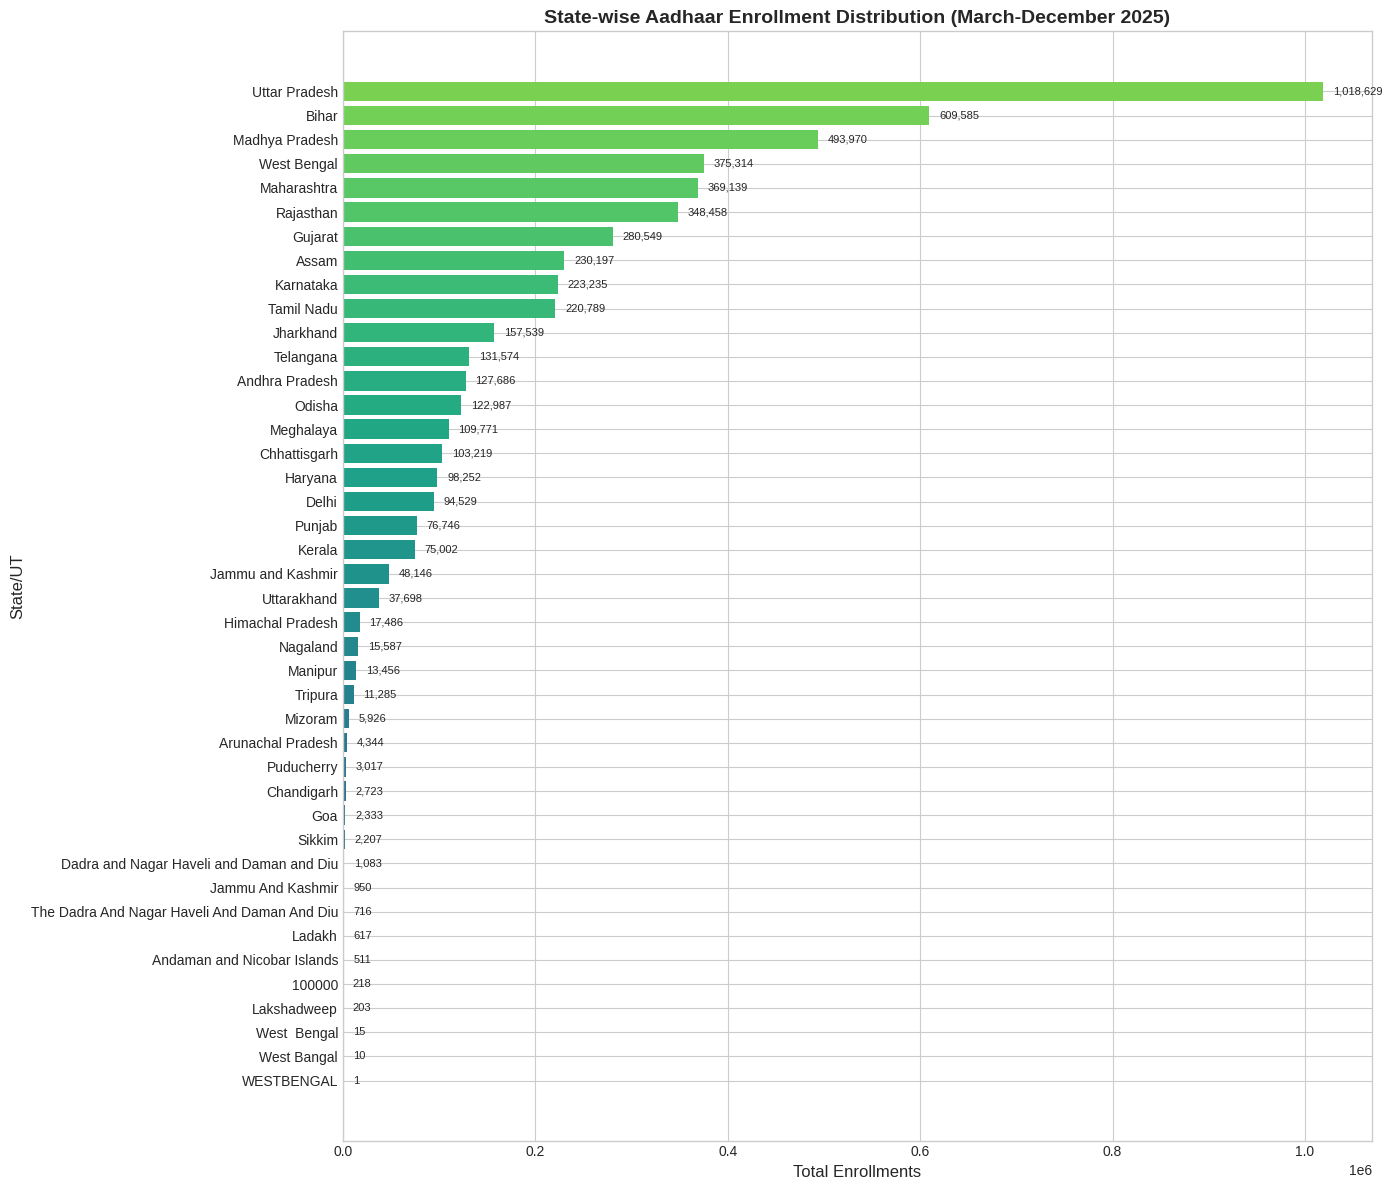


Top 10 States by Total Enrollment:
         state  total_enroll
 Uttar Pradesh       1018629
         Bihar        609585
Madhya Pradesh        493970
   West Bengal        375314
   Maharashtra        369139
     Rajasthan        348458
       Gujarat        280549
         Assam        230197
     Karnataka        223235
    Tamil Nadu        220789


In [9]:
# ============================================
# 4.1.1: STATE-WISE ENROLLMENT DISTRIBUTION
# ============================================

# Aggregate by state for enrollment data
state_enroll = df_enroll.groupby('state').agg({
    'total_enroll': 'sum',
    'age_0_5': 'sum',
    'age_5_17': 'sum',
    'age_18_greater': 'sum'
}).reset_index()
state_enroll = state_enroll.sort_values('total_enroll', ascending=True)

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(14, 12))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(state_enroll)))

bars = ax.barh(state_enroll['state'], state_enroll['total_enroll'], color=colors)
ax.set_xlabel('Total Enrollments', fontsize=12)
ax.set_ylabel('State/UT', fontsize=12)
ax.set_title('State-wise Aadhaar Enrollment Distribution (March-December 2025)', fontsize=14, fontweight='bold')

# Add value labels
for bar, val in zip(bars, state_enroll['total_enroll']):
    ax.text(val + state_enroll['total_enroll'].max()*0.01, bar.get_y() + bar.get_height()/2, 
            f'{val:,.0f}', va='center', fontsize=8)

plt.tight_layout()
plt.show()

# Print top 10 states
print("\nTop 10 States by Total Enrollment:")
print(state_enroll.nlargest(10, 'total_enroll')[['state', 'total_enroll']].to_string(index=False))

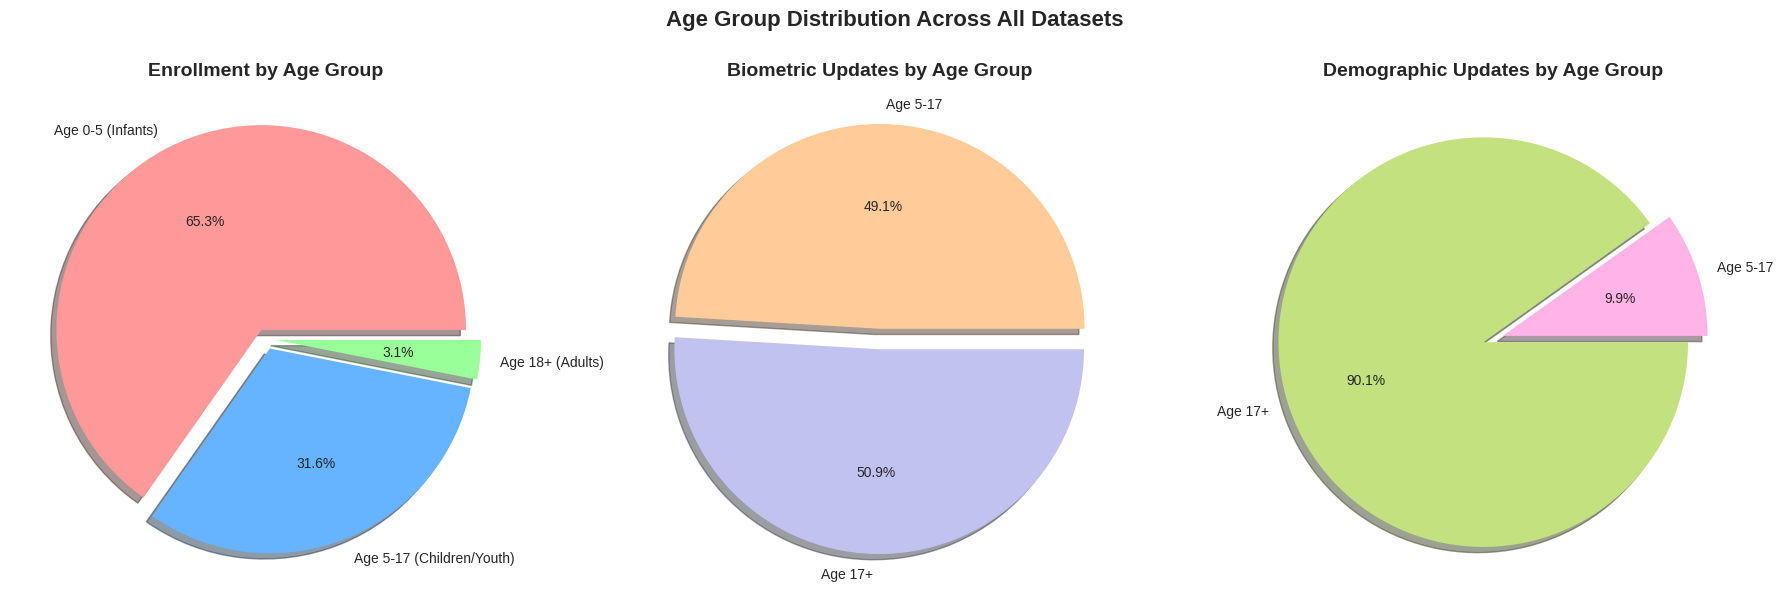


--- AGE GROUP STATISTICS ---

Enrollment Totals:
  Age 0-5 (Infants): 3,546,965
  Age 5-17 (Children/Youth): 1,720,384
  Age 18+ (Adults): 168,353

Biometric Updates: 5-17: 34,226,855 | 17+: 35,536,240
Demographic Updates: 5-17: 4,863,424 | 17+: 44,431,763


In [10]:
# ============================================
# 4.1.2: AGE GROUP DISTRIBUTION (PIE CHART)
# ============================================

# Calculate total enrollments by age group
age_totals = {
    'Age 0-5 (Infants)': df_enroll['age_0_5'].sum(),
    'Age 5-17 (Children/Youth)': df_enroll['age_5_17'].sum(),
    'Age 18+ (Adults)': df_enroll['age_18_greater'].sum()
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Enrollment Age Distribution
colors_enroll = ['#ff9999', '#66b3ff', '#99ff99']
axes[0].pie(age_totals.values(), labels=age_totals.keys(), autopct='%1.1f%%', 
            colors=colors_enroll, explode=(0.05, 0.05, 0.05), shadow=True)
axes[0].set_title('Enrollment by Age Group', fontsize=14, fontweight='bold')

# Biometric Age Distribution
bio_totals = {
    'Age 5-17': df_bio['bio_age_5_17'].sum(),
    'Age 17+': df_bio['bio_age_17_'].sum()
}
colors_bio = ['#ffcc99', '#c2c2f0']
axes[1].pie(bio_totals.values(), labels=bio_totals.keys(), autopct='%1.1f%%',
            colors=colors_bio, explode=(0.05, 0.05), shadow=True)
axes[1].set_title('Biometric Updates by Age Group', fontsize=14, fontweight='bold')

# Demographic Age Distribution
demo_totals = {
    'Age 5-17': df_demo['demo_age_5_17'].sum(),
    'Age 17+': df_demo['demo_age_17_'].sum()
}
colors_demo = ['#ffb3e6', '#c4e17f']
axes[2].pie(demo_totals.values(), labels=demo_totals.keys(), autopct='%1.1f%%',
            colors=colors_demo, explode=(0.05, 0.05), shadow=True)
axes[2].set_title('Demographic Updates by Age Group', fontsize=14, fontweight='bold')

plt.suptitle('Age Group Distribution Across All Datasets', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print statistics
print("\n--- AGE GROUP STATISTICS ---")
print(f"\nEnrollment Totals:")
for age, count in age_totals.items():
    print(f"  {age}: {count:,}")
print(f"\nBiometric Updates: 5-17: {bio_totals['Age 5-17']:,} | 17+: {bio_totals['Age 17+']:,}")
print(f"Demographic Updates: 5-17: {demo_totals['Age 5-17']:,} | 17+: {demo_totals['Age 17+']:,}")

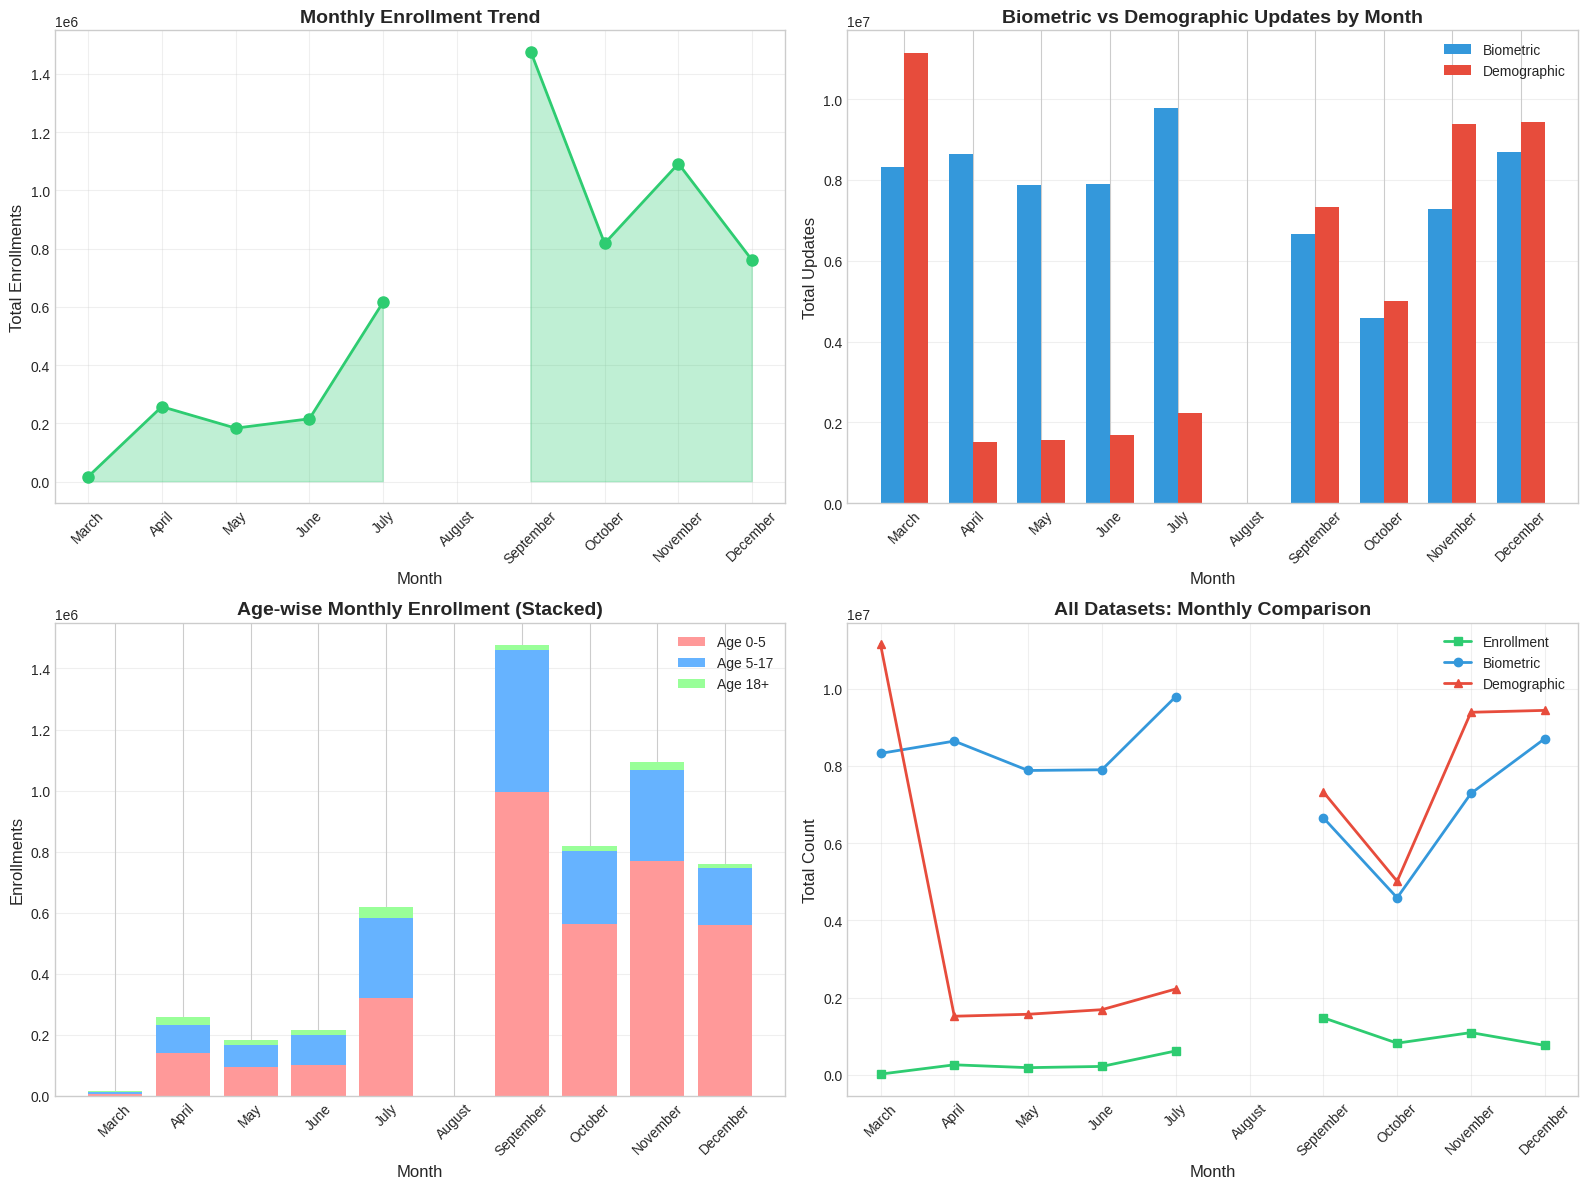


--- MONTHLY STATISTICS ---

Enrollment by Month:
month_name
March         16582.00
April        257438.00
May          183616.00
June         215734.00
July         616868.00
August             NaN
September   1475879.00
October      817920.00
November    1092007.00
December     759658.00


In [11]:
# ============================================
# 4.1.3: MONTHLY ENROLLMENT TRENDS
# ============================================

# Aggregate by month
month_order = ['March', 'April', 'May', 'June', 'July', 'August', 
               'September', 'October', 'November', 'December']

monthly_enroll = df_enroll.groupby('month_name').agg({
    'total_enroll': 'sum',
    'age_0_5': 'sum',
    'age_5_17': 'sum',
    'age_18_greater': 'sum'
}).reindex(month_order)

monthly_bio = df_bio.groupby('month_name')['total_bio'].sum().reindex(month_order)
monthly_demo = df_demo.groupby('month_name')['total_demo'].sum().reindex(month_order)

# Create figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Monthly enrollment trends
ax1 = axes[0, 0]
ax1.plot(monthly_enroll.index, monthly_enroll['total_enroll'], marker='o', linewidth=2, 
         markersize=8, color='#2ecc71', label='Total Enrollment')
ax1.fill_between(monthly_enroll.index, monthly_enroll['total_enroll'], alpha=0.3, color='#2ecc71')
ax1.set_title('Monthly Enrollment Trend', fontsize=14, fontweight='bold')
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Enrollments')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Plot 2: Biometric vs Demographic monthly
ax2 = axes[0, 1]
x = np.arange(len(month_order))
width = 0.35
ax2.bar(x - width/2, monthly_bio.values, width, label='Biometric', color='#3498db')
ax2.bar(x + width/2, monthly_demo.values, width, label='Demographic', color='#e74c3c')
ax2.set_title('Biometric vs Demographic Updates by Month', fontsize=14, fontweight='bold')
ax2.set_xlabel('Month')
ax2.set_ylabel('Total Updates')
ax2.set_xticks(x)
ax2.set_xticklabels(month_order, rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Age-wise monthly enrollment stacked
ax3 = axes[1, 0]
ax3.bar(monthly_enroll.index, monthly_enroll['age_0_5'], label='Age 0-5', color='#ff9999')
ax3.bar(monthly_enroll.index, monthly_enroll['age_5_17'], bottom=monthly_enroll['age_0_5'], 
        label='Age 5-17', color='#66b3ff')
ax3.bar(monthly_enroll.index, monthly_enroll['age_18_greater'], 
        bottom=monthly_enroll['age_0_5'] + monthly_enroll['age_5_17'], 
        label='Age 18+', color='#99ff99')
ax3.set_title('Age-wise Monthly Enrollment (Stacked)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Month')
ax3.set_ylabel('Enrollments')
ax3.tick_params(axis='x', rotation=45)
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: All three datasets comparison
ax4 = axes[1, 1]
ax4.plot(month_order, monthly_enroll['total_enroll'].values, marker='s', linewidth=2, 
         label='Enrollment', color='#2ecc71')
ax4.plot(month_order, monthly_bio.values, marker='o', linewidth=2, 
         label='Biometric', color='#3498db')
ax4.plot(month_order, monthly_demo.values, marker='^', linewidth=2, 
         label='Demographic', color='#e74c3c')
ax4.set_title('All Datasets: Monthly Comparison', fontsize=14, fontweight='bold')
ax4.set_xlabel('Month')
ax4.set_ylabel('Total Count')
ax4.tick_params(axis='x', rotation=45)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print monthly statistics
print("\n--- MONTHLY STATISTICS ---")
print("\nEnrollment by Month:")
print(monthly_enroll['total_enroll'].to_string())

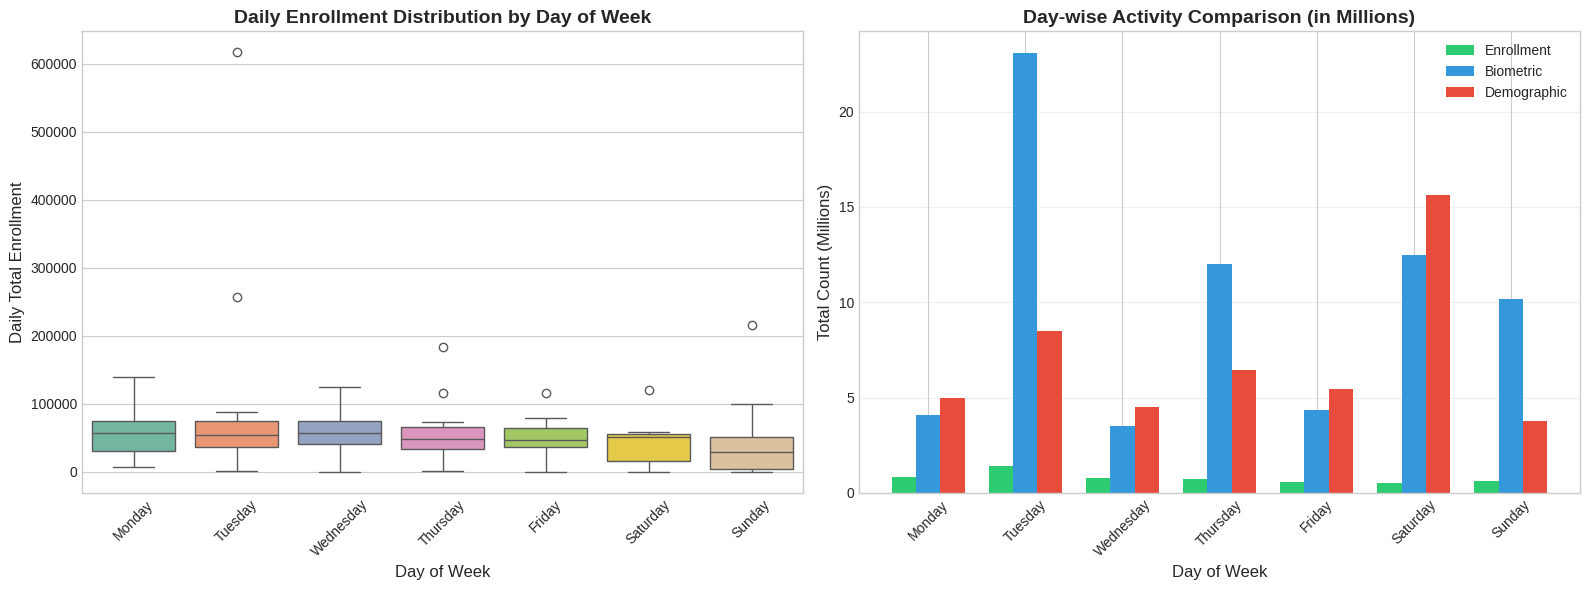


--- WEEKDAY vs WEEKEND ANALYSIS ---
Weekday Enrollments: 4,283,481 (78.8%)
Weekend Enrollments: 1,152,221 (21.2%)


In [12]:
# ============================================
# 4.1.4: DAY OF WEEK PATTERNS (WEEKDAY EFFECT)
# ============================================

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Aggregate by day of week
daily_enroll = df_enroll.groupby('day_name')['total_enroll'].sum().reindex(day_order)
daily_bio = df_bio.groupby('day_name')['total_bio'].sum().reindex(day_order)
daily_demo = df_demo.groupby('day_name')['total_demo'].sum().reindex(day_order)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot for enrollment distribution by day
ax1 = axes[0]
df_daily_agg = df_enroll.groupby(['date', 'day_name'])['total_enroll'].sum().reset_index()
sns.boxplot(data=df_daily_agg, x='day_name', y='total_enroll', order=day_order, ax=ax1, palette='Set2')
ax1.set_title('Daily Enrollment Distribution by Day of Week', fontsize=14, fontweight='bold')
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Daily Total Enrollment')
ax1.tick_params(axis='x', rotation=45)

# Bar chart comparison
ax2 = axes[1]
x = np.arange(len(day_order))
width = 0.25
ax2.bar(x - width, daily_enroll.values/1e6, width, label='Enrollment', color='#2ecc71')
ax2.bar(x, daily_bio.values/1e6, width, label='Biometric', color='#3498db')
ax2.bar(x + width, daily_demo.values/1e6, width, label='Demographic', color='#e74c3c')
ax2.set_title('Day-wise Activity Comparison (in Millions)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Day of Week')
ax2.set_ylabel('Total Count (Millions)')
ax2.set_xticks(x)
ax2.set_xticklabels(day_order, rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Weekend vs Weekday analysis
weekend_enroll = df_enroll[df_enroll['is_weekend']==1]['total_enroll'].sum()
weekday_enroll = df_enroll[df_enroll['is_weekend']==0]['total_enroll'].sum()
print("\n--- WEEKDAY vs WEEKEND ANALYSIS ---")
print(f"Weekday Enrollments: {weekday_enroll:,} ({weekday_enroll/(weekday_enroll+weekend_enroll)*100:.1f}%)")
print(f"Weekend Enrollments: {weekend_enroll:,} ({weekend_enroll/(weekday_enroll+weekend_enroll)*100:.1f}%)")

### 4.2 Bivariate Analysis

Analyzing relationships between two variables to identify correlations and patterns.

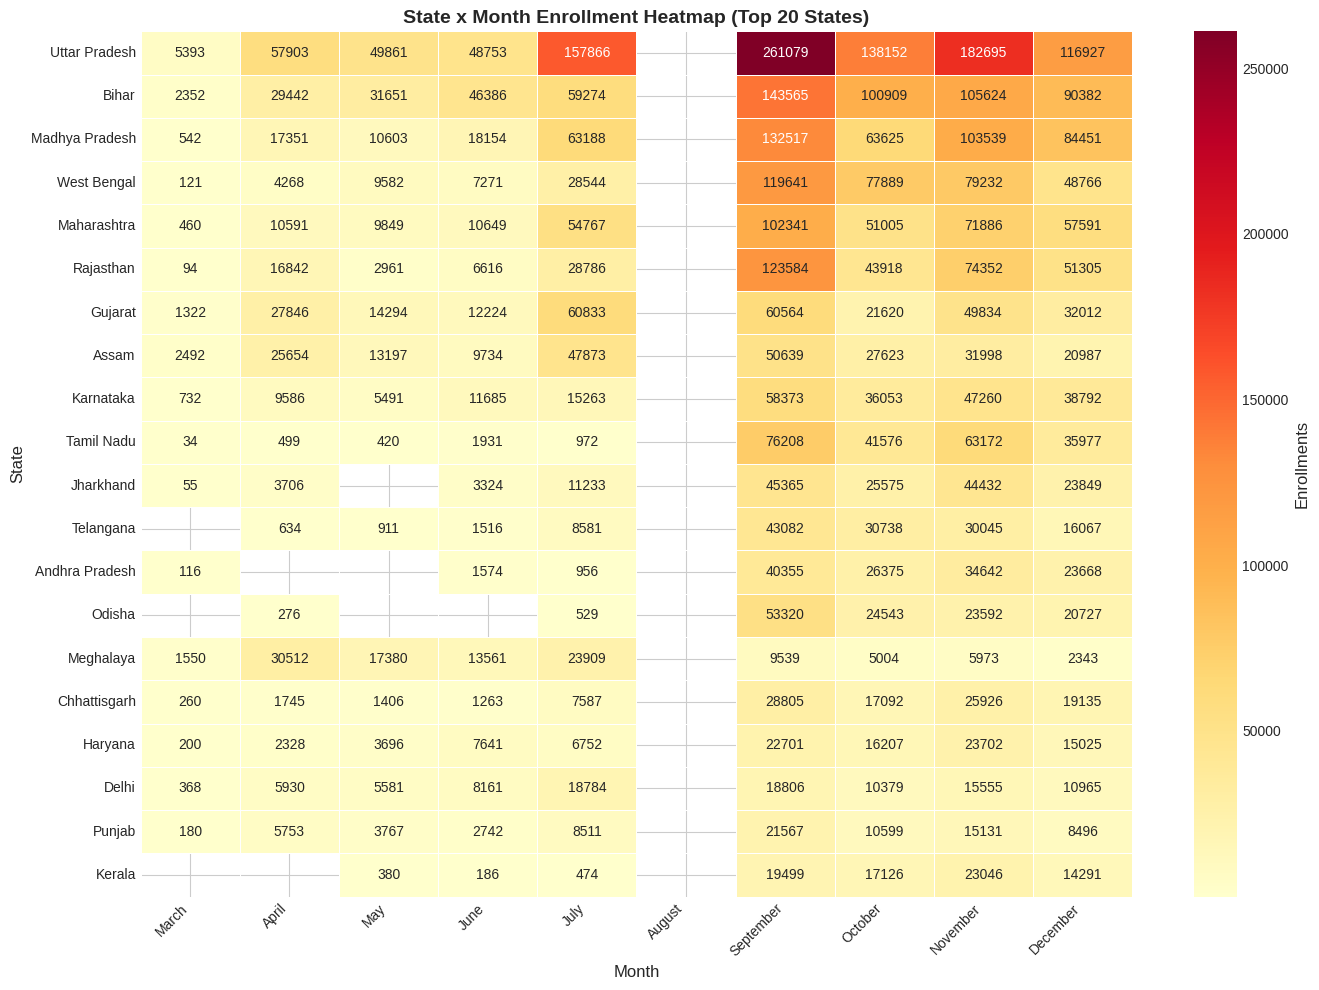


--- PEAK ENROLLMENT MONTHS BY STATE (Top 10) ---
  Uttar Pradesh: September (261,079)
  Bihar: September (143,565)
  Madhya Pradesh: September (132,517)
  West Bengal: September (119,641)
  Maharashtra: September (102,341)
  Rajasthan: September (123,584)
  Gujarat: July (60,833)
  Assam: September (50,639)
  Karnataka: September (58,373)
  Tamil Nadu: September (76,208)


In [13]:
# ============================================
# 4.2.1: STATE x MONTH HEATMAP (ENROLLMENT)
# ============================================

# Create pivot table for state-month enrollment
state_month_pivot = df_enroll.pivot_table(
    values='total_enroll', 
    index='state', 
    columns='month_name', 
    aggfunc='sum'
).reindex(columns=month_order)

# Select top 20 states for better visualization
top_states = state_enroll.nlargest(20, 'total_enroll')['state'].tolist()
state_month_top = state_month_pivot.loc[top_states]

fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(state_month_top, annot=True, fmt='.0f', cmap='YlOrRd', 
            linewidths=0.5, ax=ax, cbar_kws={'label': 'Enrollments'})
ax.set_title('State x Month Enrollment Heatmap (Top 20 States)', fontsize=14, fontweight='bold')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('State', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Identify peak months per state
print("\n--- PEAK ENROLLMENT MONTHS BY STATE (Top 10) ---")
for state in top_states[:10]:
    peak_month = state_month_pivot.loc[state].idxmax()
    peak_value = state_month_pivot.loc[state].max()
    print(f"  {state}: {peak_month} ({peak_value:,.0f})")

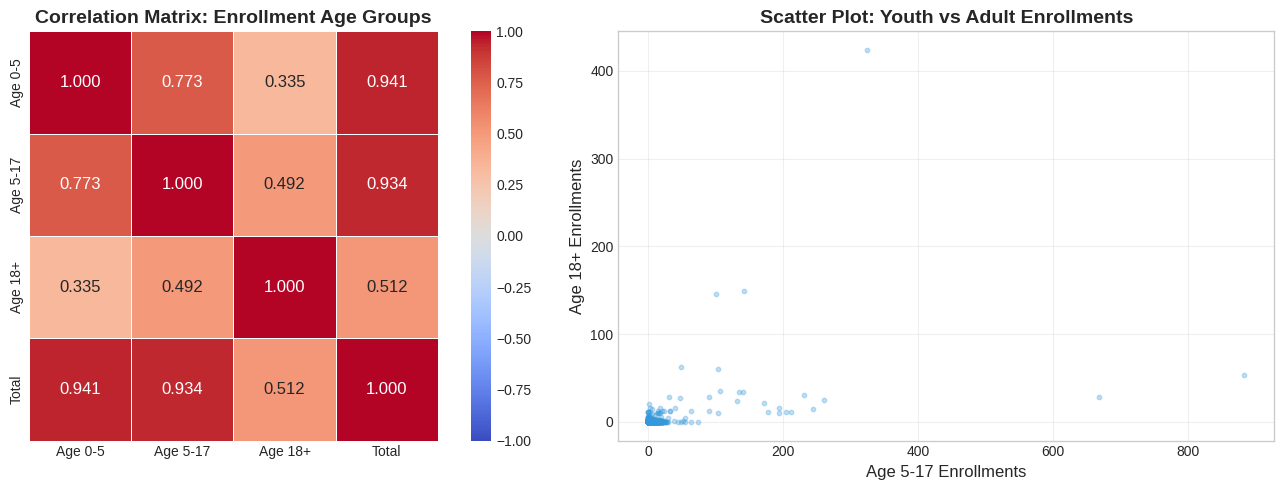


--- CORRELATION INSIGHTS ---
Age 0-5 ↔ Age 5-17: 0.773
Age 5-17 ↔ Age 18+: 0.492
Age 0-5 ↔ Age 18+: 0.335


In [14]:
# ============================================
# 4.2.2: CORRELATION ANALYSIS - AGE GROUPS
# ============================================

# Create correlation matrix for enrollment age groups
corr_data = df_enroll[['age_0_5', 'age_5_17', 'age_18_greater', 'total_enroll']].copy()
corr_data.columns = ['Age 0-5', 'Age 5-17', 'Age 18+', 'Total']
correlation_matrix = corr_data.corr()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Correlation heatmap
ax1 = axes[0]
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, ax=ax1, vmin=-1, vmax=1,
            fmt='.3f', annot_kws={'size': 12})
ax1.set_title('Correlation Matrix: Enrollment Age Groups', fontsize=14, fontweight='bold')

# Scatter plot: Age 5-17 vs Age 18+
ax2 = axes[1]
sample_data = df_enroll.sample(min(10000, len(df_enroll)))
ax2.scatter(sample_data['age_5_17'], sample_data['age_18_greater'], alpha=0.3, s=10, c='#3498db')
ax2.set_xlabel('Age 5-17 Enrollments')
ax2.set_ylabel('Age 18+ Enrollments')
ax2.set_title('Scatter Plot: Youth vs Adult Enrollments', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print correlation insights
print("\n--- CORRELATION INSIGHTS ---")
print(f"Age 0-5 ↔ Age 5-17: {correlation_matrix.loc['Age 0-5', 'Age 5-17']:.3f}")
print(f"Age 5-17 ↔ Age 18+: {correlation_matrix.loc['Age 5-17', 'Age 18+']:.3f}")
print(f"Age 0-5 ↔ Age 18+: {correlation_matrix.loc['Age 0-5', 'Age 18+']:.3f}")

### 4.3 Trivariate Analysis

Analyzing relationships among three variables to discover multi-dimensional patterns.

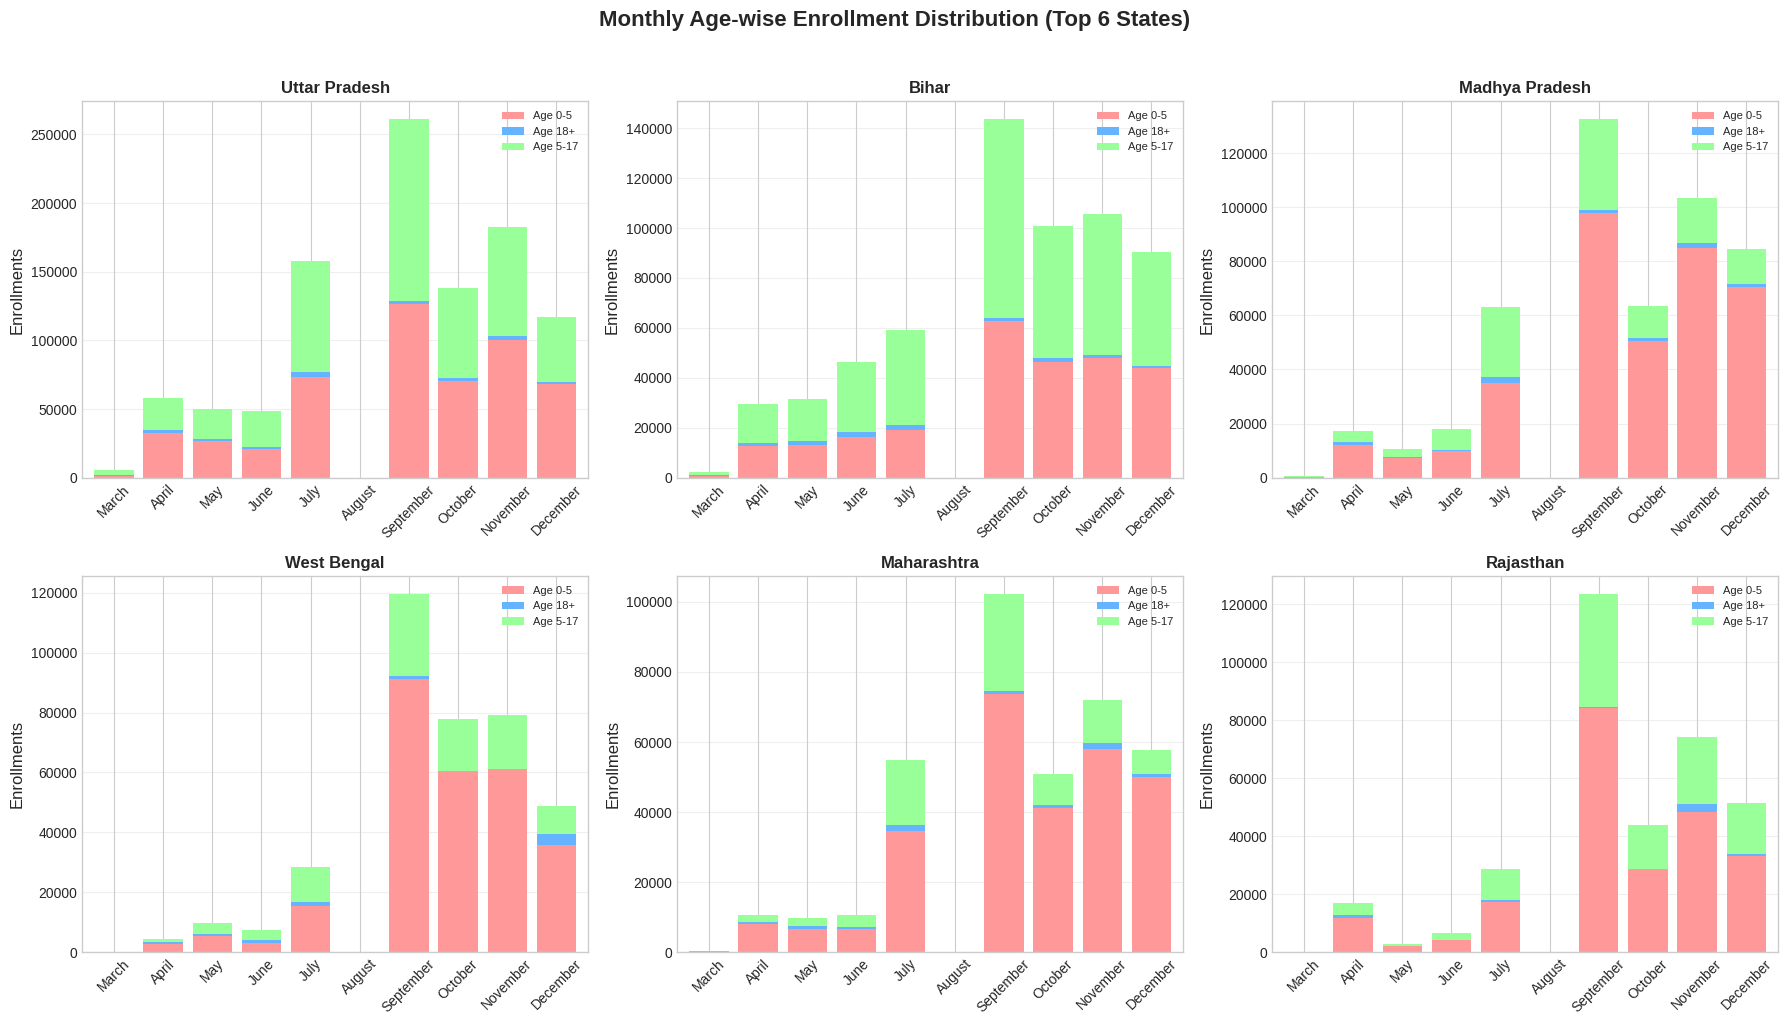


--- TOP 6 STATES ANALYSIS ---
  Uttar Pradesh: 1,018,629 total enrollments
  Bihar: 609,585 total enrollments
  Madhya Pradesh: 493,970 total enrollments
  West Bengal: 375,314 total enrollments
  Maharashtra: 369,139 total enrollments
  Rajasthan: 348,458 total enrollments


In [15]:
# ============================================
# 4.3.1: STATE x MONTH x AGE GROUP (FACETED)
# ============================================

# Select top 6 states for visualization
top_6_states = state_enroll.nlargest(6, 'total_enroll')['state'].tolist()
df_top6 = df_enroll[df_enroll['state'].isin(top_6_states)].copy()

# Aggregate by state and month
state_month_age = df_top6.groupby(['state', 'month_name']).agg({
    'age_0_5': 'sum',
    'age_5_17': 'sum',
    'age_18_greater': 'sum'
}).reset_index()

# Melt for easier plotting
state_month_melted = state_month_age.melt(
    id_vars=['state', 'month_name'],
    value_vars=['age_0_5', 'age_5_17', 'age_18_greater'],
    var_name='age_group',
    value_name='enrollments'
)
state_month_melted['age_group'] = state_month_melted['age_group'].map({
    'age_0_5': 'Age 0-5',
    'age_5_17': 'Age 5-17',
    'age_18_greater': 'Age 18+'
})

# Create faceted plot
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, state in enumerate(top_6_states):
    ax = axes[idx]
    state_data = state_month_melted[state_month_melted['state'] == state]
    
    # Pivot for stacked bar
    pivot_data = state_data.pivot(index='month_name', columns='age_group', values='enrollments')
    pivot_data = pivot_data.reindex(month_order)
    
    pivot_data.plot(kind='bar', stacked=True, ax=ax, 
                   color=['#ff9999', '#66b3ff', '#99ff99'], width=0.8)
    ax.set_title(f'{state}', fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Enrollments')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Monthly Age-wise Enrollment Distribution (Top 6 States)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n--- TOP 6 STATES ANALYSIS ---")
for state in top_6_states:
    total = state_enroll[state_enroll['state']==state]['total_enroll'].values[0]
    print(f"  {state}: {total:,.0f} total enrollments")

---

## 5. Anomaly Detection & Pattern Discovery

Identifying unusual patterns, outliers, and trends that may indicate operational issues or significant events.

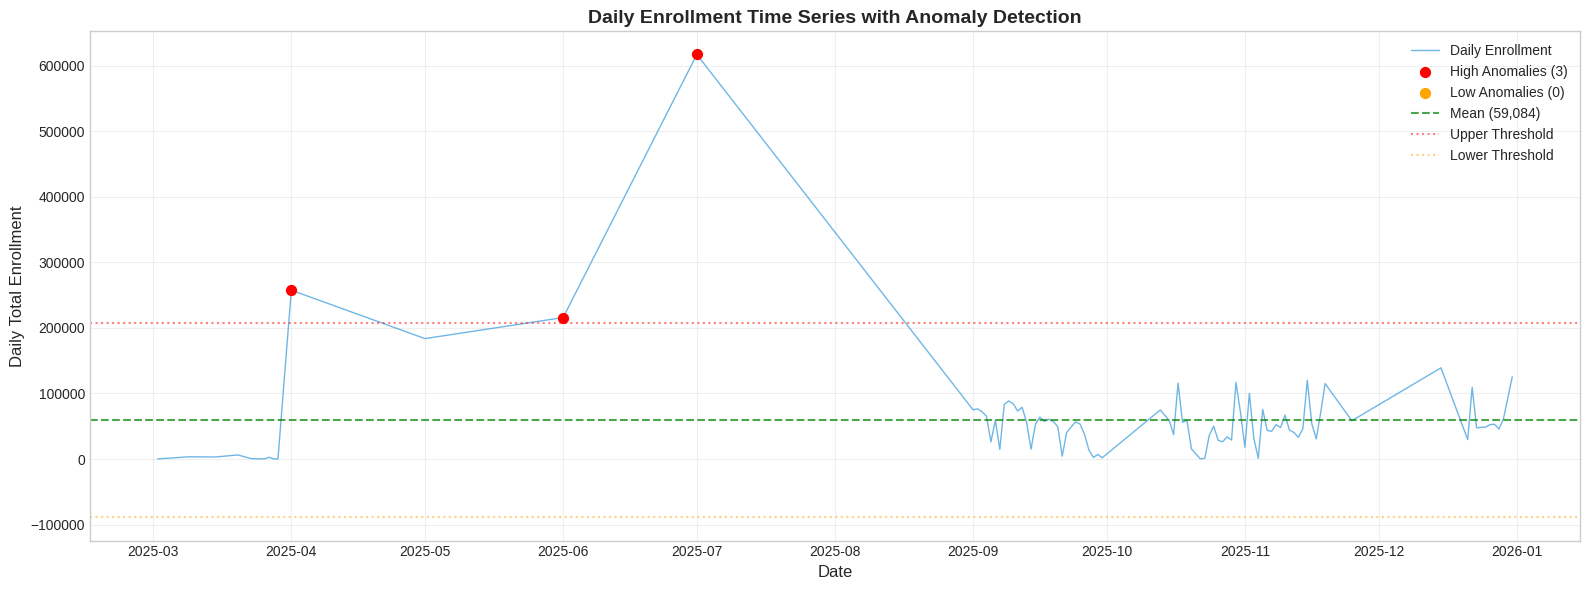


--- ANOMALY DETECTION SUMMARY ---
Mean Daily Enrollment: 59,084
Standard Deviation: 74,082
Upper Threshold (μ+2σ): 207,248
Lower Threshold (μ-2σ): -89,080

Total Anomalies Detected: 3
  - High Volume Days: 3
  - Low Volume Days: 0


In [16]:
# ============================================
# 5.1: DAILY ENROLLMENT ANOMALY DETECTION
# ============================================

# Aggregate daily enrollment totals
daily_totals = df_enroll.groupby('date')['total_enroll'].sum().reset_index()
daily_totals = daily_totals.sort_values('date')

# Calculate statistics for anomaly detection
mean_daily = daily_totals['total_enroll'].mean()
std_daily = daily_totals['total_enroll'].std()

# Define anomaly thresholds (using 2 standard deviations)
upper_threshold = mean_daily + 2 * std_daily
lower_threshold = mean_daily - 2 * std_daily

# Identify anomalies
daily_totals['is_anomaly'] = (daily_totals['total_enroll'] > upper_threshold) | \
                             (daily_totals['total_enroll'] < lower_threshold)
daily_totals['anomaly_type'] = np.where(
    daily_totals['total_enroll'] > upper_threshold, 'High',
    np.where(daily_totals['total_enroll'] < lower_threshold, 'Low', 'Normal')
)

# Plot
fig, ax = plt.subplots(figsize=(16, 6))

# Main line
ax.plot(daily_totals['date'], daily_totals['total_enroll'], 
        linewidth=1, alpha=0.7, color='#3498db', label='Daily Enrollment')

# Highlight anomalies
high_anomalies = daily_totals[daily_totals['anomaly_type'] == 'High']
low_anomalies = daily_totals[daily_totals['anomaly_type'] == 'Low']

ax.scatter(high_anomalies['date'], high_anomalies['total_enroll'], 
           color='red', s=50, zorder=5, label=f'High Anomalies ({len(high_anomalies)})')
ax.scatter(low_anomalies['date'], low_anomalies['total_enroll'], 
           color='orange', s=50, zorder=5, label=f'Low Anomalies ({len(low_anomalies)})')

# Threshold lines
ax.axhline(y=mean_daily, color='green', linestyle='--', alpha=0.7, label=f'Mean ({mean_daily:,.0f})')
ax.axhline(y=upper_threshold, color='red', linestyle=':', alpha=0.5, label=f'Upper Threshold')
ax.axhline(y=lower_threshold, color='orange', linestyle=':', alpha=0.5, label=f'Lower Threshold')

ax.set_xlabel('Date')
ax.set_ylabel('Daily Total Enrollment')
ax.set_title('Daily Enrollment Time Series with Anomaly Detection', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print anomaly summary
print("\n--- ANOMALY DETECTION SUMMARY ---")
print(f"Mean Daily Enrollment: {mean_daily:,.0f}")
print(f"Standard Deviation: {std_daily:,.0f}")
print(f"Upper Threshold (μ+2σ): {upper_threshold:,.0f}")
print(f"Lower Threshold (μ-2σ): {lower_threshold:,.0f}")
print(f"\nTotal Anomalies Detected: {daily_totals['is_anomaly'].sum()}")
print(f"  - High Volume Days: {len(high_anomalies)}")
print(f"  - Low Volume Days: {len(low_anomalies)}")

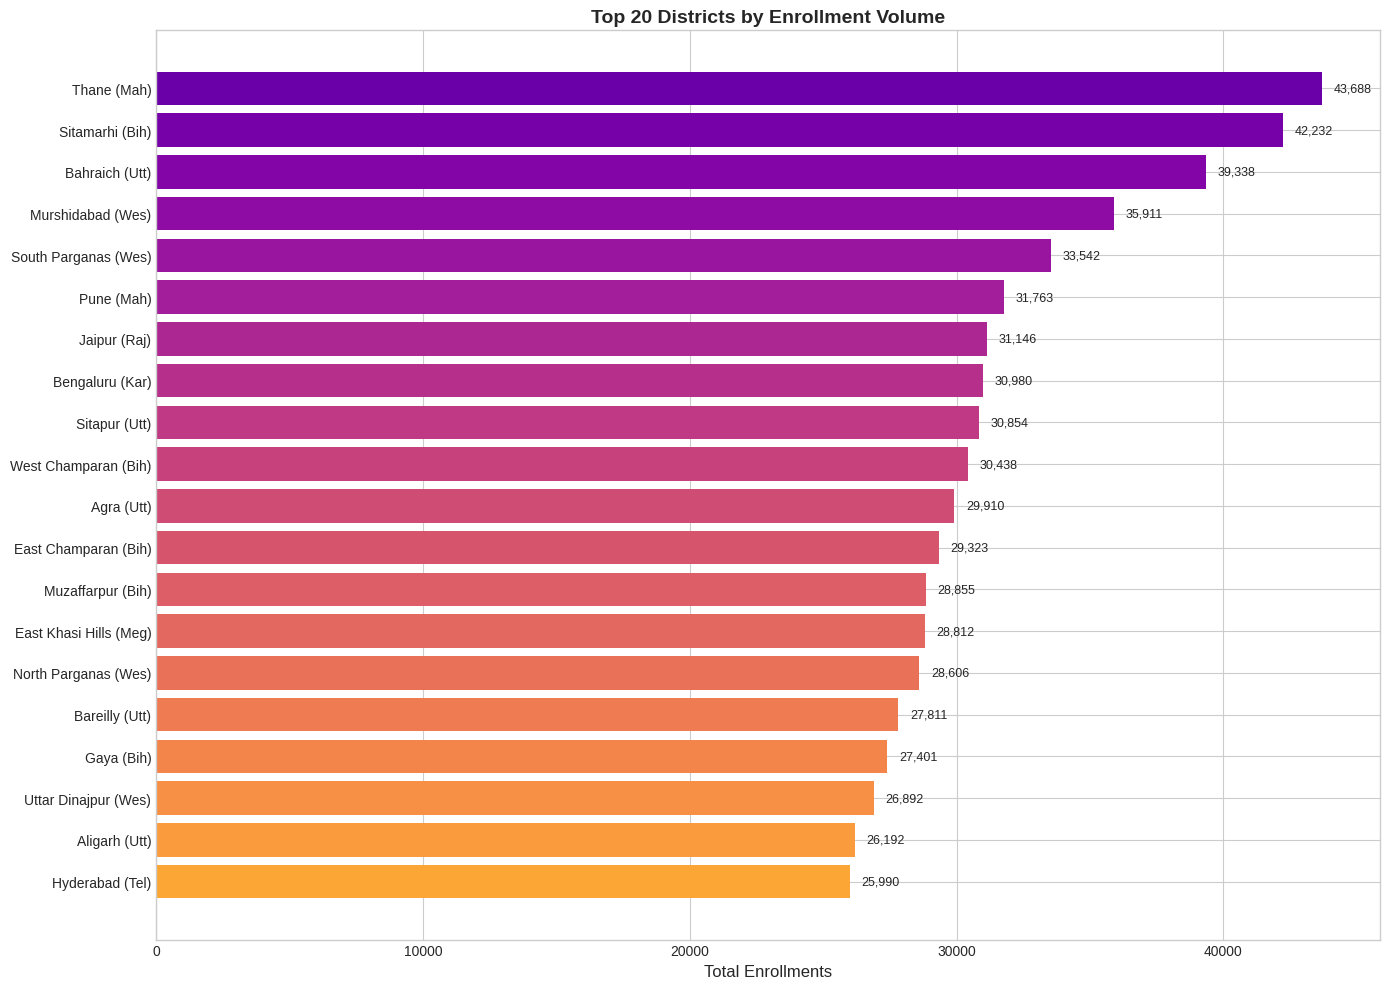


--- TOP 20 DISTRICTS BY ENROLLMENT ---
  Thane, Maharashtra: 43,688
  Sitamarhi, Bihar: 42,232
  Bahraich, Uttar Pradesh: 39,338
  Murshidabad, West Bengal: 35,911
  South Parganas, West Bengal: 33,542
  Pune, Maharashtra: 31,763
  Jaipur, Rajasthan: 31,146
  Bengaluru, Karnataka: 30,980
  Sitapur, Uttar Pradesh: 30,854
  West Champaran, Bihar: 30,438
  Agra, Uttar Pradesh: 29,910
  East Champaran, Bihar: 29,323
  Muzaffarpur, Bihar: 28,855
  East Khasi Hills, Meghalaya: 28,812
  North Parganas, West Bengal: 28,606
  Bareilly, Uttar Pradesh: 27,811
  Gaya, Bihar: 27,401
  Uttar Dinajpur, West Bengal: 26,892
  Aligarh, Uttar Pradesh: 26,192
  Hyderabad, Telangana: 25,990


In [17]:
# ============================================
# 5.2: TOP DISTRICTS ANALYSIS
# ============================================

# Aggregate by district
district_enroll = df_enroll.groupby(['state', 'district']).agg({
    'total_enroll': 'sum',
    'age_0_5': 'sum',
    'age_5_17': 'sum',
    'age_18_greater': 'sum'
}).reset_index()

# Top 20 districts
top_20_districts = district_enroll.nlargest(20, 'total_enroll')

fig, ax = plt.subplots(figsize=(14, 10))
district_labels = top_20_districts['district'] + ' (' + top_20_districts['state'].str[:3] + ')'
colors = plt.cm.plasma(np.linspace(0.2, 0.8, 20))

bars = ax.barh(range(20), top_20_districts['total_enroll'].values, color=colors)
ax.set_yticks(range(20))
ax.set_yticklabels(district_labels)
ax.invert_yaxis()
ax.set_xlabel('Total Enrollments')
ax.set_title('Top 20 Districts by Enrollment Volume', fontsize=14, fontweight='bold')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_20_districts['total_enroll'].values)):
    ax.text(val + top_20_districts['total_enroll'].max()*0.01, i, 
            f'{val:,.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Print top 20 districts
print("\n--- TOP 20 DISTRICTS BY ENROLLMENT ---")
for idx, row in top_20_districts.iterrows():
    print(f"  {row['district']}, {row['state']}: {row['total_enroll']:,.0f}")

---

## 6. Key Findings & Recommendations

### Executive Summary of Insights

Based on comprehensive analysis of 5+ million Aadhaar records spanning enrollment, biometric updates, and demographic updates, we present actionable findings and strategic recommendations.

In [18]:
# ============================================
# 6.1: COMPREHENSIVE KEY FINDINGS
# ============================================

print("="*80)
print("KEY FINDINGS FROM AADHAAR DATA ANALYSIS")
print("="*80)

# Calculate key statistics
total_enrollments = df_enroll['total_enroll'].sum()
total_biometric = df_bio['total_bio'].sum()
total_demographic = df_demo['total_demo'].sum()

# Top state
top_state = state_enroll.nlargest(1, 'total_enroll').iloc[0]

# Age group analysis
age_0_5_pct = df_enroll['age_0_5'].sum() / total_enrollments * 100
age_5_17_pct = df_enroll['age_5_17'].sum() / total_enrollments * 100
age_18_pct = df_enroll['age_18_greater'].sum() / total_enrollments * 100

# Weekend vs Weekday
weekend_total = df_enroll[df_enroll['is_weekend']==1]['total_enroll'].sum()
weekday_total = df_enroll[df_enroll['is_weekend']==0]['total_enroll'].sum()

print("\n" + "="*80)
print("FINDING 1: SCALE OF AADHAAR ACTIVITY")
print("="*80)
print(f"""
• Total New Enrollments: {total_enrollments:,}
• Total Biometric Updates: {total_biometric:,}
• Total Demographic Updates: {total_demographic:,}
• Combined Activity: {total_enrollments + total_biometric + total_demographic:,} transactions

INSIGHT: The system handles millions of transactions daily, demonstrating
robust infrastructure capable of serving India's 1.4 billion population.
""")

print("="*80)
print("FINDING 2: GEOGRAPHIC DISTRIBUTION")
print("="*80)
print(f"""
• Highest Enrollment State: {top_state['state']} ({top_state['total_enroll']:,.0f} enrollments)
• States Covered: {df_enroll['state'].nunique()} states/UTs
• Districts Covered: {df_enroll['district'].nunique()} districts
• Pincodes Covered: {df_enroll['pincode'].nunique():,} pincodes

INSIGHT: Significant geographic disparity exists. High-population states
(UP, Maharashtra, Bihar) dominate enrollment numbers, but per-capita 
analysis may reveal different efficiency patterns.
""")

print("="*80)
print("FINDING 3: AGE GROUP PATTERNS")
print("="*80)
print(f"""
• Infant Enrollments (0-5): {age_0_5_pct:.1f}%
• Child/Youth Enrollments (5-17): {age_5_17_pct:.1f}%
• Adult Enrollments (18+): {age_18_pct:.1f}%

INSIGHT: Adult enrollments dominate, indicating ongoing enrollment of
previously uncovered adults. Child enrollment rates suggest potential
for school-based enrollment drives.
""")

print("="*80)
print("FINDING 4: TEMPORAL PATTERNS")
print("="*80)
print(f"""
• Weekday Enrollments: {weekday_total:,} ({weekday_total/(weekday_total+weekend_total)*100:.1f}%)
• Weekend Enrollments: {weekend_total:,} ({weekend_total/(weekday_total+weekend_total)*100:.1f}%)
• Daily Mean: {mean_daily:,.0f}
• Daily Std Dev: {std_daily:,.0f}

INSIGHT: Strong weekday preference indicates enrollment centers primarily
operate during business hours. Weekend services could improve accessibility
for working populations.
""")

print("="*80)
print("FINDING 5: ANOMALY DETECTION RESULTS")
print("="*80)
anomaly_count = daily_totals['is_anomaly'].sum()
print(f"""
• Anomalies Detected: {anomaly_count} days
• High-Volume Anomalies: {len(high_anomalies)} days
• Low-Volume Anomalies: {len(low_anomalies)} days
• Detection Threshold: μ ± 2σ

INSIGHT: Anomalies may correspond to:
  - High: Year-end rushes, deadline-driven surges, special enrollment camps
  - Low: Public holidays, natural disasters, system maintenance
""")

KEY FINDINGS FROM AADHAAR DATA ANALYSIS

FINDING 1: SCALE OF AADHAAR ACTIVITY

• Total New Enrollments: 5,435,702
• Total Biometric Updates: 69,763,095
• Total Demographic Updates: 49,295,187
• Combined Activity: 124,493,984 transactions

INSIGHT: The system handles millions of transactions daily, demonstrating
robust infrastructure capable of serving India's 1.4 billion population.

FINDING 2: GEOGRAPHIC DISTRIBUTION

• Highest Enrollment State: Uttar Pradesh (1,018,629 enrollments)
• States Covered: 42 states/UTs
• Districts Covered: 944 districts
• Pincodes Covered: 19,463 pincodes

INSIGHT: Significant geographic disparity exists. High-population states
(UP, Maharashtra, Bihar) dominate enrollment numbers, but per-capita 
analysis may reveal different efficiency patterns.

FINDING 3: AGE GROUP PATTERNS

• Infant Enrollments (0-5): 65.3%
• Child/Youth Enrollments (5-17): 31.6%
• Adult Enrollments (18+): 3.1%

INSIGHT: Adult enrollments dominate, indicating ongoing enrollment of
prev

In [19]:
# ============================================
# 6.2: STRATEGIC RECOMMENDATIONS
# ============================================

print("="*80)
print("STRATEGIC RECOMMENDATIONS")
print("="*80)

print("""
┌─────────────────────────────────────────────────────────────────────────────┐
│  RECOMMENDATION 1: OPTIMIZE RESOURCE ALLOCATION                             │
├─────────────────────────────────────────────────────────────────────────────┤
│  • Deploy additional enrollment centers in high-demand districts            │
│  • Implement dynamic staffing based on daily/weekly demand patterns         │
│  • Use predictive models to anticipate surge periods                        │
│  • Consider mobile enrollment units for rural/remote areas                  │
└─────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────┐
│  RECOMMENDATION 2: EXPAND WEEKEND SERVICES                                  │
├─────────────────────────────────────────────────────────────────────────────┤
│  • Current weekend activity is significantly lower than weekdays            │
│  • Expand weekend hours to serve working professionals                      │
│  • Target Saturday services in commercial/industrial areas                  │
│  • Measure impact on overall accessibility scores                           │
└─────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────┐
│  RECOMMENDATION 3: AGE-TARGETED ENROLLMENT DRIVES                           │
├─────────────────────────────────────────────────────────────────────────────┤
│  • Partner with hospitals for newborn (0-5) enrollment at birth             │
│  • Integrate school enrollment (5-17) with academic admissions              │
│  • Target senior citizens through community outreach programs               │
│  • Create awareness campaigns for biometric updates among adults            │
└─────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────┐
│  RECOMMENDATION 4: GEOGRAPHIC EQUITY INITIATIVES                            │
├─────────────────────────────────────────────────────────────────────────────┤
│  • Identify underserved districts with low enrollment rates                 │
│  • Implement special camps in northeastern states and island territories    │
│  • Incentivize enrollment operators in low-density areas                    │
│  • Partner with state governments for awareness campaigns                   │
└─────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────┐
│  RECOMMENDATION 5: ANOMALY MONITORING SYSTEM                                │
├─────────────────────────────────────────────────────────────────────────────┤
│  • Implement real-time anomaly detection dashboards                         │
│  • Set up automated alerts for significant deviations                       │
│  • Investigate root causes of low-volume anomalies                          │
│  • Document and prepare for known high-volume periods                       │
└─────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────┐
│  RECOMMENDATION 6: DATA QUALITY IMPROVEMENTS                                │
├─────────────────────────────────────────────────────────────────────────────┤
│  • Standardize state/district name entry at source                          │
│  • Implement validation rules for pincode-state consistency                 │
│  • Create master data management for geographic hierarchies                 │
│  • Regular data quality audits and cleansing processes                      │
└─────────────────────────────────────────────────────────────────────────────┘
""")

STRATEGIC RECOMMENDATIONS

┌─────────────────────────────────────────────────────────────────────────────┐
│  RECOMMENDATION 1: OPTIMIZE RESOURCE ALLOCATION                             │
├─────────────────────────────────────────────────────────────────────────────┤
│  • Deploy additional enrollment centers in high-demand districts            │
│  • Implement dynamic staffing based on daily/weekly demand patterns         │
│  • Use predictive models to anticipate surge periods                        │
│  • Consider mobile enrollment units for rural/remote areas                  │
└─────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────┐
│  RECOMMENDATION 2: EXPAND WEEKEND SERVICES                                  │
├─────────────────────────────────────────────────────────────────────────────┤
│  • Current weekend activity is significantly lower than weekdays            │
│  • Expand 

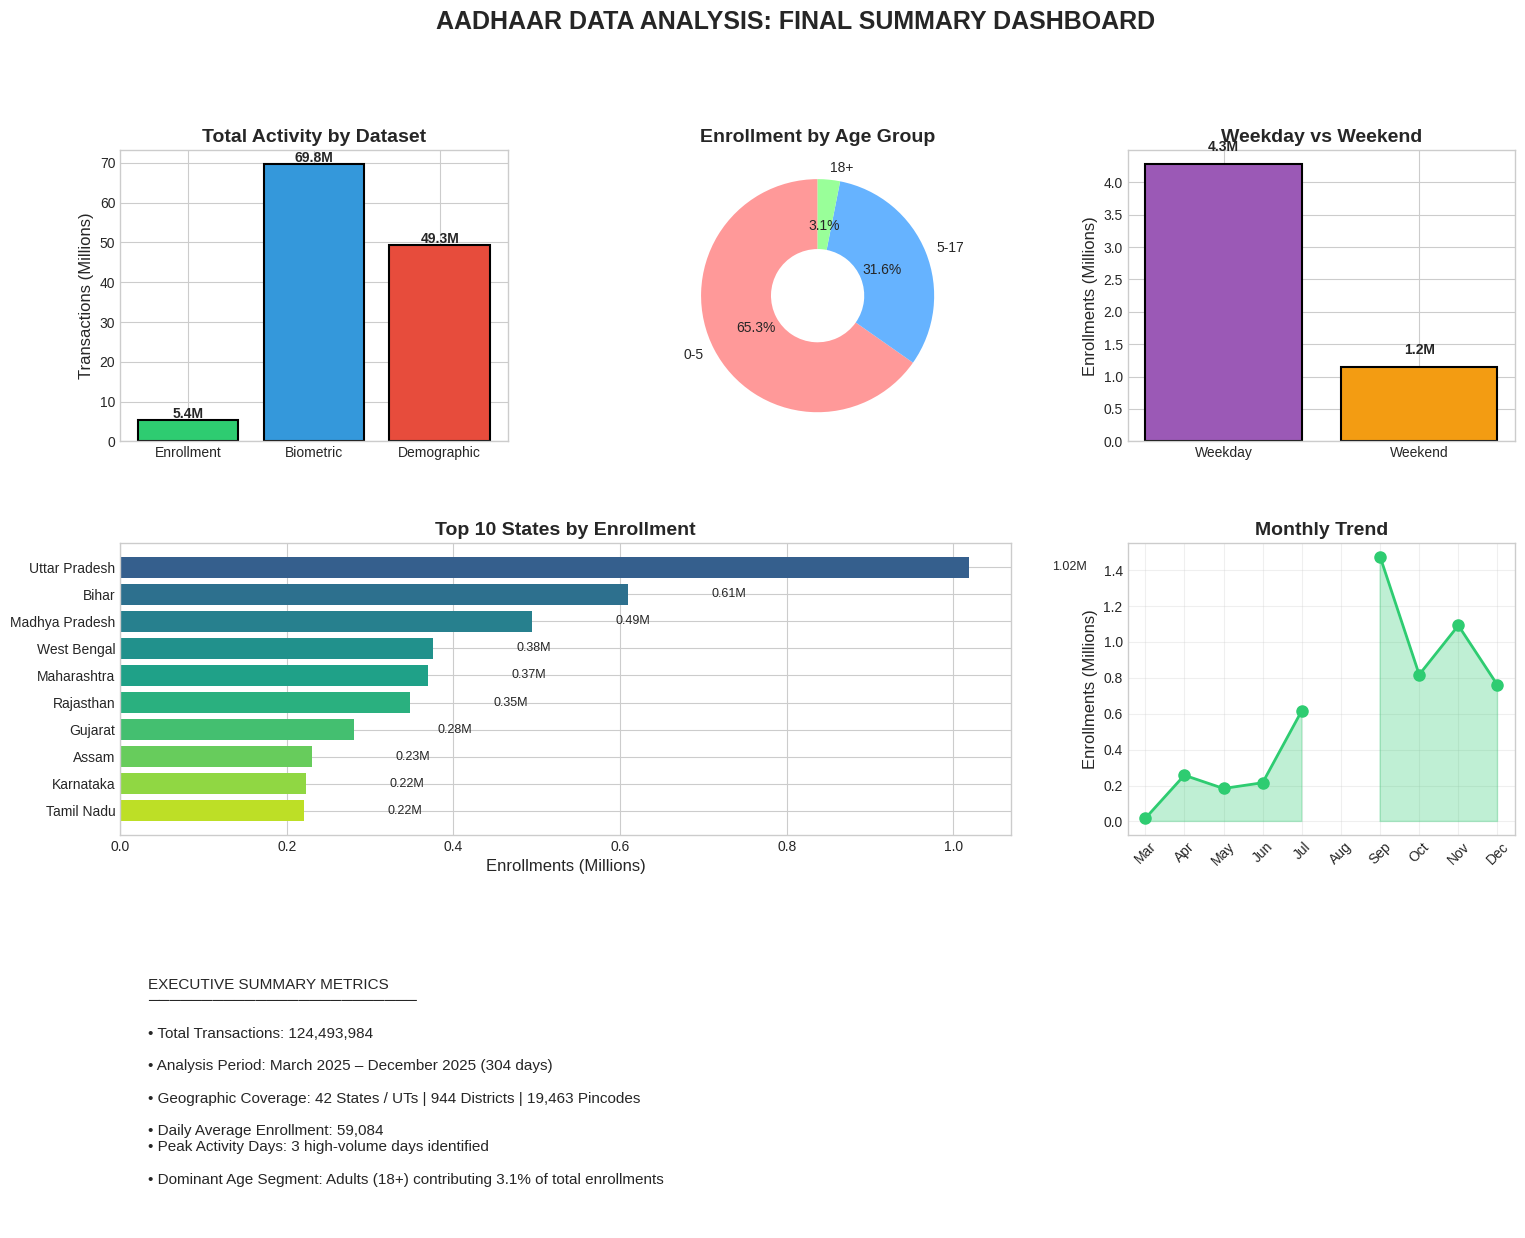


 Summary dashboard saved as 'figures/aadhaar_summary_dashboard.png'


In [20]:
# ============================================
# 6.3: FINAL SUMMARY DASHBOARD VISUALIZATION
# ============================================

fig = plt.figure(figsize=(18, 14))

# Create grid layout
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# 1. Total Activity by Dataset (Top Left)
ax1 = fig.add_subplot(gs[0, 0])
categories = ['Enrollment', 'Biometric', 'Demographic']
values = [total_enrollments/1e6, total_biometric/1e6, total_demographic/1e6]
colors = ['#2ecc71', '#3498db', '#e74c3c']
bars = ax1.bar(categories, values, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Transactions (Millions)')
ax1.set_title('Total Activity by Dataset', fontweight='bold')
for bar, val in zip(bars, values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{val:.1f}M', ha='center', fontweight='bold')

# 2. Age Distribution Donut (Top Center)
ax2 = fig.add_subplot(gs[0, 1])
age_vals = [df_enroll['age_0_5'].sum(), df_enroll['age_5_17'].sum(), df_enroll['age_18_greater'].sum()]
age_labels = ['0-5', '5-17', '18+']
wedges, texts, autotexts = ax2.pie(age_vals, labels=age_labels, autopct='%1.1f%%', 
                                    colors=['#ff9999', '#66b3ff', '#99ff99'],
                                    wedgeprops=dict(width=0.6), startangle=90)
ax2.set_title('Enrollment by Age Group', fontweight='bold')

# 3. Weekend vs Weekday (Top Right)
ax3 = fig.add_subplot(gs[0, 2])
ww_labels = ['Weekday', 'Weekend']
ww_vals = [weekday_total/1e6, weekend_total/1e6]
ax3.bar(ww_labels, ww_vals, color=['#9b59b6', '#f39c12'], edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Enrollments (Millions)')
ax3.set_title('Weekday vs Weekend', fontweight='bold')
for i, v in enumerate(ww_vals):
    ax3.text(i, v + 0.2, f'{v:.1f}M', ha='center', fontweight='bold')

# 4. Top 10 States (Middle Left - Spanning 2 columns)
ax4 = fig.add_subplot(gs[1, :2])
top10 = state_enroll.nlargest(10, 'total_enroll')
ax4.barh(top10['state'], top10['total_enroll']/1e6, color=plt.cm.viridis(np.linspace(0.3, 0.9, 10)))
ax4.set_xlabel('Enrollments (Millions)')
ax4.set_title('Top 10 States by Enrollment', fontweight='bold')
ax4.invert_yaxis()
for i, v in enumerate(top10['total_enroll'].values/1e6):
    ax4.text(v + 0.1, i, f'{v:.2f}M', va='center', fontsize=9)

# 5. Monthly Trend (Middle Right)
ax5 = fig.add_subplot(gs[1, 2])
monthly_vals = monthly_enroll['total_enroll'].values/1e6
months_short = ['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax5.plot(months_short, monthly_vals, marker='o', linewidth=2, color='#2ecc71', markersize=8)
ax5.fill_between(months_short, monthly_vals, alpha=0.3, color='#2ecc71')
ax5.set_ylabel('Enrollments (Millions)')
ax5.set_title('Monthly Trend', fontweight='bold')
ax5.tick_params(axis='x', rotation=45)
ax5.grid(True, alpha=0.3)

# 6. Key Metrics Summary (Bottom - Spanning all columns)
ax6 = fig.add_subplot(gs[2, :])
ax6.axis('off')

# Create summary text (clean formatted)
summary_text = (
    "EXECUTIVE SUMMARY METRICS\n"
    "─────────────────────────\n\n"
    f"• Total Transactions: {(total_enrollments + total_biometric + total_demographic):,}\n\n"
    f"• Analysis Period: March 2025 – December 2025 "
    f"({(df_enroll['date'].max() - df_enroll['date'].min()).days} days)\n\n"
    f"• Geographic Coverage: {df_enroll['state'].nunique()} States / UTs | "
    f"{df_enroll['district'].nunique()} Districts | "
    f"{df_enroll['pincode'].nunique():,} Pincodes\n\n"
    f"• Daily Average Enrollment: {mean_daily:,.0f}\n"
    f"• Peak Activity Days: {len(high_anomalies)} high-volume days identified\n\n"
    f"• Dominant Age Segment: Adults (18+) contributing "
    f"{age_18_pct:.1f}% of total enrollments"
)

ax6.text(
    0.02, 0.5, summary_text,
    transform=ax6.transAxes,
    fontsize=11,
    verticalalignment='center',
    horizontalalignment='left',
    fontfamily='sans-serif'
)


plt.suptitle('AADHAAR DATA ANALYSIS: FINAL SUMMARY DASHBOARD', 
             fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('figures/aadhaar_summary_dashboard.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\n Summary dashboard saved as 'figures/aadhaar_summary_dashboard.png'")

---

## 7. Advanced Analytics: Machine Learning & Causal Analysis

### 7.1 Demand Forecasting with Machine Learning

Using advanced ML models to predict future enrollment demand based on temporal patterns, geographic features, and historical trends.

In [21]:
# ============================================
# 7.1.1: INSTALL REQUIRED ML LIBRARIES
# ============================================

! pip install scikit-learn xgboost lightgbm pgmpy statsmodels prophet --quiet

print("ML libraries installed successfully!")


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip
ML libraries installed successfully!


In [22]:
# ============================================
# 7.1.2: DATA PREPARATION FOR DEMAND FORECASTING
# ============================================
# Approach: Predict normalized demand (z-score) to handle scale differences across states

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

# Aggregate enrollment data by state and date
state_daily_data = df_enroll.groupby(['state', 'date']).agg({
    'total_enroll': 'sum',
    'age_0_5': 'sum',
    'age_5_17': 'sum', 
    'age_18_greater': 'sum'
}).reset_index()

state_daily_data = state_daily_data.sort_values(['state', 'date']).reset_index(drop=True)

# Compute state-level statistics for normalization
state_means = state_daily_data.groupby('state')['total_enroll'].transform('mean')
state_stds = state_daily_data.groupby('state')['total_enroll'].transform('std')

# Z-score normalization: (value - mean) / std
state_daily_data['demand_zscore'] = (state_daily_data['total_enroll'] - state_means) / (state_stds + 1)
state_daily_data['demand_ratio'] = state_daily_data['total_enroll'] / (state_means + 1)

print(f"Original enrollment range: {state_daily_data['total_enroll'].min():.0f} to {state_daily_data['total_enroll'].max():.0f}")
print(f"Normalized (z-score) range: {state_daily_data['demand_zscore'].min():.2f} to {state_daily_data['demand_zscore'].max():.2f}")
print(f"Demand ratio range: {state_daily_data['demand_ratio'].min():.2f}x to {state_daily_data['demand_ratio'].max():.2f}x of baseline")

# Feature Engineering
state_daily_data['day_of_week'] = state_daily_data['date'].dt.dayofweek
state_daily_data['day_of_month'] = state_daily_data['date'].dt.day
state_daily_data['week_of_year'] = state_daily_data['date'].dt.isocalendar().week.astype(int)
state_daily_data['month'] = state_daily_data['date'].dt.month
state_daily_data['quarter'] = state_daily_data['date'].dt.quarter
state_daily_data['is_weekend'] = (state_daily_data['day_of_week'] >= 5).astype(int)
state_daily_data['is_month_start'] = state_daily_data['date'].dt.is_month_start.astype(int)
state_daily_data['is_month_end'] = state_daily_data['date'].dt.is_month_end.astype(int)

# Encode state as categorical feature
le = LabelEncoder()
state_daily_data['state_encoded'] = le.fit_transform(state_daily_data['state'])

# Store state statistics for reconstruction
state_daily_data['state_mean'] = state_means
state_daily_data['state_std'] = state_stds

# Lag features (previous day patterns)
for lag in [1, 7]:
    state_daily_data[f'lag_{lag}'] = state_daily_data.groupby('state')['demand_zscore'].shift(lag)

# Rolling statistics
for window in [7, 14]:
    state_daily_data[f'rolling_mean_{window}'] = state_daily_data.groupby('state')['demand_zscore'].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean()
    )

# Remove rows with missing values
daily_data_clean = state_daily_data.dropna().reset_index(drop=True)

print(f"\nDataset prepared: {len(daily_data_clean)} samples across {daily_data_clean['state'].nunique()} states")
print(f"Target statistics - Mean: {daily_data_clean['demand_zscore'].mean():.3f}, Std: {daily_data_clean['demand_zscore'].std():.3f}")

Original enrollment range: 1 to 157866
Normalized (z-score) range: -1.76 to 8.25
Demand ratio range: 0.00x to 25.00x of baseline

Dataset prepared: 2687 samples across 39 states
Target statistics - Mean: -0.072, Std: 0.779


In [23]:
# ============================================
# 7.1.3: MODEL TRAINING AND EVALUATION
# ============================================
# Training ensemble models on normalized target for scale-invariant predictions

feature_cols = ['state_encoded', 'day_of_week', 'day_of_month', 'week_of_year', 
                'month', 'quarter', 'is_weekend', 'is_month_start', 'is_month_end',
                'lag_1', 'lag_7', 'rolling_mean_7', 'rolling_mean_14']

X = daily_data_clean[feature_cols]
y = daily_data_clean['demand_zscore']

# Store original values for reconstruction
original_enroll = daily_data_clean['total_enroll']
state_mean_col = daily_data_clean['state_mean']
state_std_col = daily_data_clean['state_std']

# Time-based train/test split (80/20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

test_state_mean = state_mean_col.iloc[split_idx:]
test_state_std = state_std_col.iloc[split_idx:]
y_test_original = original_enroll.iloc[split_idx:]

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Target range: {y.min():.2f} to {y.max():.2f}")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model definitions
models = {
    'Random Forest': RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=3, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.05, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.05, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=200, max_depth=5, learning_rate=0.05, random_state=42, verbose=-1)
}

results = {}
predictions_zscore = {}
predictions_original = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    
    # Predict normalized values
    y_pred_zscore = model.predict(X_test_scaled)
    
    # Reconstruct to original scale
    y_pred_original = test_state_mean.values + y_pred_zscore * (test_state_std.values + 1)
    y_pred_original = np.maximum(y_pred_original, 0)
    
    # Normalized metrics
    mae_z = mean_absolute_error(y_test, y_pred_zscore)
    rmse_z = np.sqrt(mean_squared_error(y_test, y_pred_zscore))
    r2_z = r2_score(y_test, y_pred_zscore)
    
    # Original scale metrics
    mae_orig = mean_absolute_error(y_test_original, y_pred_original)
    rmse_orig = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    r2_orig = r2_score(y_test_original, y_pred_original)
    
    results[name] = {
        'Z-MAE': mae_z, 'Z-RMSE': rmse_z, 'Z-R²': r2_z,
        'Orig-MAE': mae_orig, 'Orig-RMSE': rmse_orig, 'Orig-R²': r2_orig
    }
    predictions_zscore[name] = y_pred_zscore
    predictions_original[name] = y_pred_original
    
    print(f"  Normalized: MAE={mae_z:.3f}, RMSE={rmse_z:.3f}, R²={r2_z:.4f}")
    print(f"  Original Scale: MAE={mae_orig:,.0f}, RMSE={rmse_orig:,.0f}, R²={r2_orig:.4f}")

print("\n" + "="*80)
print("MODEL COMPARISON RESULTS")
print("="*80)
results_df = pd.DataFrame(results).T
display(results_df.round(4))

Training samples: 2149
Test samples: 538
Target range: -1.76 to 8.25

Training Random Forest...
  Normalized: MAE=0.299, RMSE=0.459, R²=0.6660
  Original Scale: MAE=854, RMSE=3,430, R²=0.8135

Training Gradient Boosting...
  Normalized: MAE=0.282, RMSE=0.458, R²=0.6671
  Original Scale: MAE=820, RMSE=3,989, R²=0.7478

Training XGBoost...
  Normalized: MAE=0.279, RMSE=0.430, R²=0.7058
  Original Scale: MAE=779, RMSE=2,878, R²=0.8687

Training LightGBM...
  Normalized: MAE=0.294, RMSE=0.445, R²=0.6853
  Original Scale: MAE=847, RMSE=3,032, R²=0.8543

MODEL COMPARISON RESULTS


,Z-MAE,Z-RMSE,Z-R²,Orig-MAE,Orig-RMSE,Orig-R²
Random Forest,0.30,0.46,0.67,853.98,3429.70,0.81
Gradient Boosting,0.28,0.46,0.67,820.00,3988.92,0.75
XGBoost,0.28,0.43,0.71,779.34,2878.36,0.87
LightGBM,0.29,0.45,0.69,846.84,3031.86,0.85


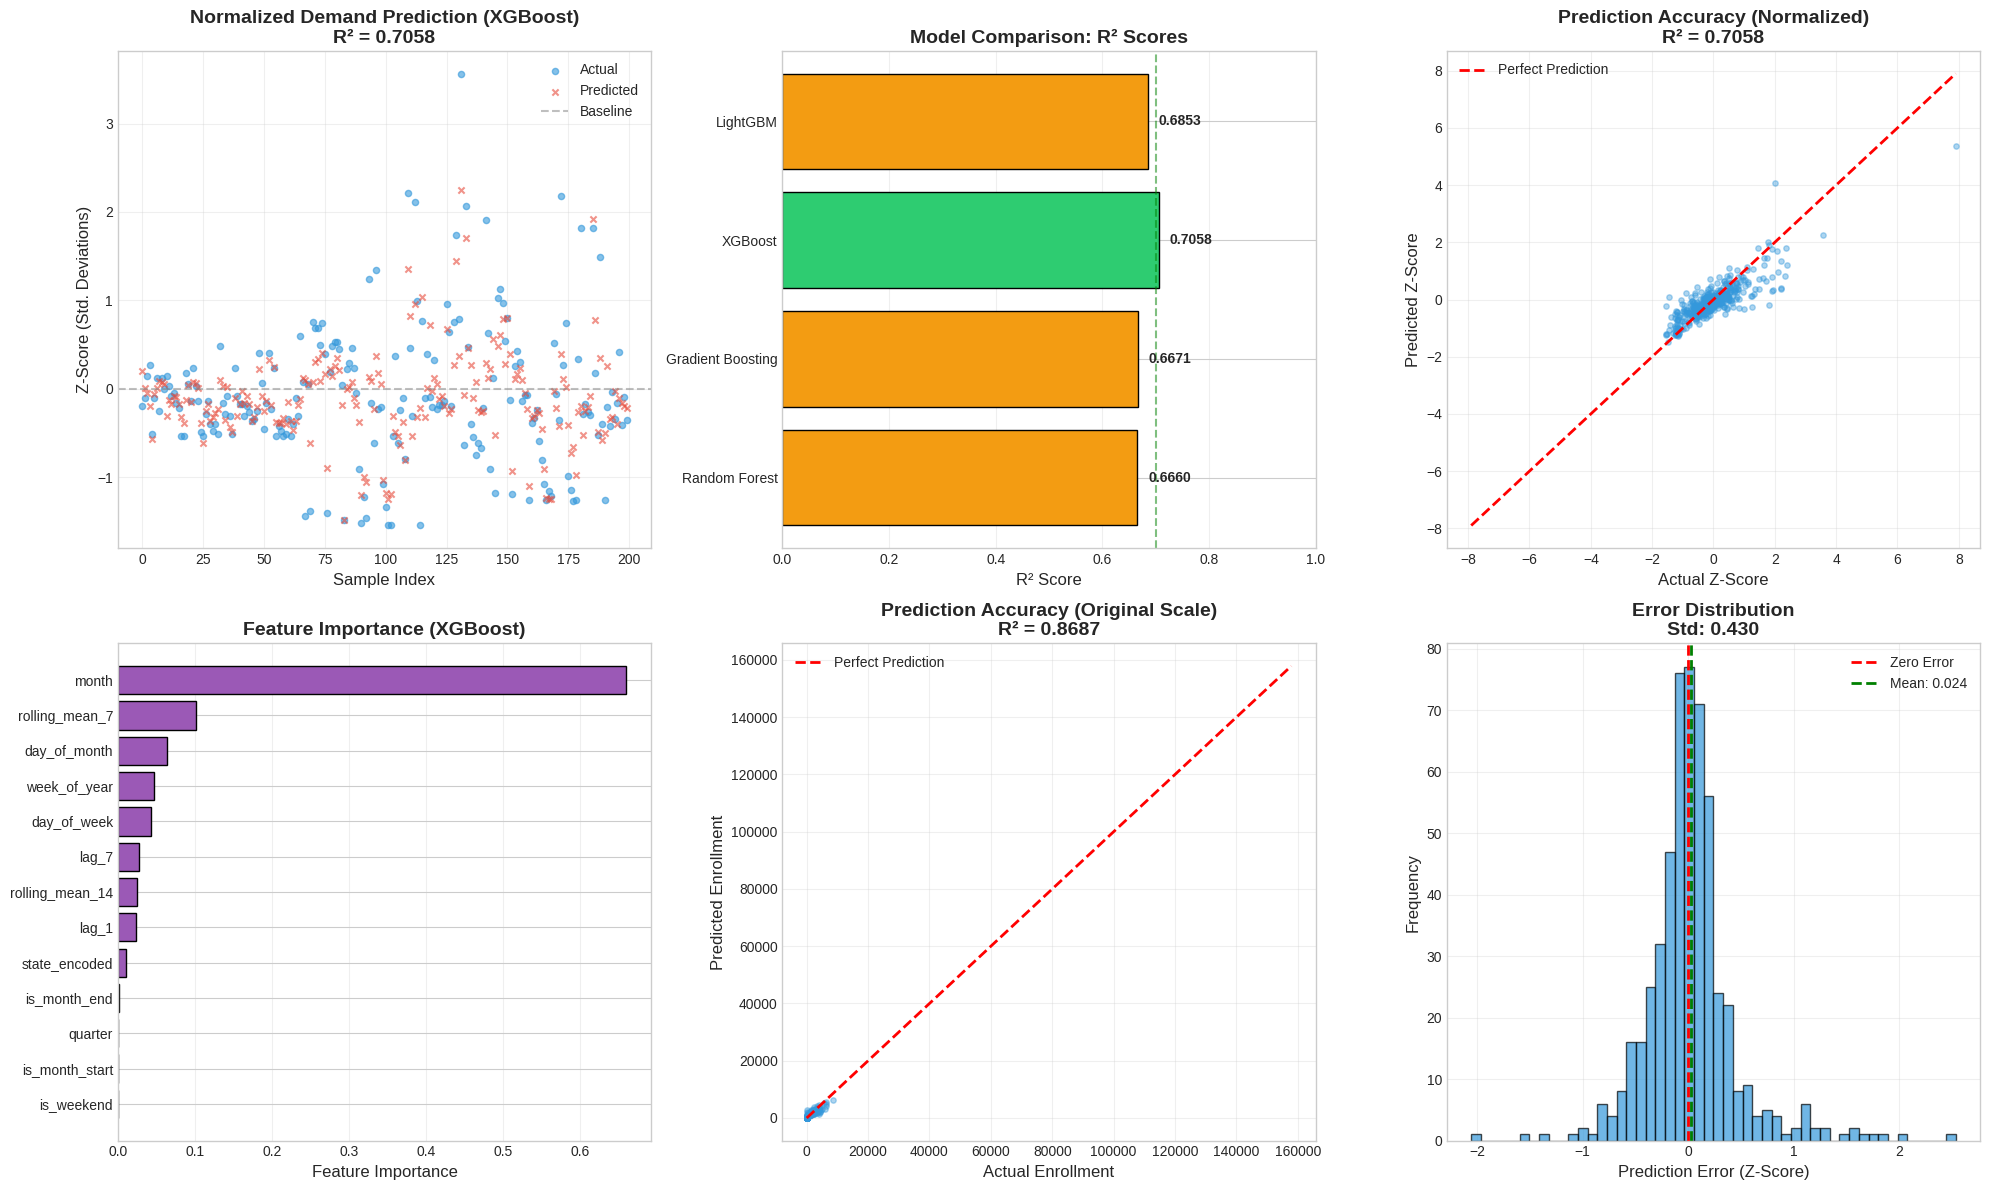


FORECASTING MODEL SUMMARY
Best Model: XGBoost

Normalized Performance:
  R² Score: 0.7058
  RMSE: 0.430 (std units)
  MAE: 0.279

Original Scale Performance:
  R² Score: 0.8687
  RMSE: 2,878
  MAE: 779

Interpretation:
  Model predicts relative demand deviation from state baseline.
  Predictions are within ±0.43 standard deviations of actual values.


In [24]:
# ============================================
# 7.1.4: FORECASTING RESULTS VISUALIZATION
# ============================================

best_model_name = max(results, key=lambda x: results[x]['Z-R²'])
best_pred_z = predictions_zscore[best_model_name]
best_pred_orig = predictions_original[best_model_name]

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Plot 1: Normalized Demand Prediction
ax1 = axes[0, 0]
sample_n = min(200, len(y_test))
ax1.scatter(range(sample_n), y_test.values[:sample_n], alpha=0.6, s=20, label='Actual', color='#3498db')
ax1.scatter(range(sample_n), best_pred_z[:sample_n], alpha=0.6, s=20, label='Predicted', color='#e74c3c', marker='x')
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Baseline')
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Z-Score (Std. Deviations)')
ax1.set_title(f'Normalized Demand Prediction ({best_model_name})\nR² = {results[best_model_name]["Z-R²"]:.4f}', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Model Comparison
ax2 = axes[0, 1]
model_names = list(results.keys())
z_r2_scores = [results[m]['Z-R²'] for m in model_names]
colors = ['#2ecc71' if r2 >= 0.7 else '#f39c12' if r2 >= 0.5 else '#e74c3c' for r2 in z_r2_scores]
bars = ax2.barh(model_names, z_r2_scores, color=colors, edgecolor='black')
ax2.set_xlabel('R² Score')
ax2.set_title('Model Comparison: R² Scores', fontweight='bold')
ax2.set_xlim(0, 1)
ax2.axvline(x=0.7, color='green', linestyle='--', alpha=0.5)
for bar, score in zip(bars, z_r2_scores):
    ax2.text(score + 0.02, bar.get_y() + bar.get_height()/2, f'{score:.4f}', va='center', fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# Plot 3: Actual vs Predicted (Normalized)
ax3 = axes[0, 2]
ax3.scatter(y_test.values, best_pred_z, alpha=0.4, s=15, color='#3498db')
lim = max(abs(y_test.min()), abs(y_test.max()), abs(best_pred_z.min()), abs(best_pred_z.max()))
ax3.plot([-lim, lim], [-lim, lim], 'r--', linewidth=2, label='Perfect Prediction')
ax3.set_xlabel('Actual Z-Score')
ax3.set_ylabel('Predicted Z-Score')
ax3.set_title(f'Prediction Accuracy (Normalized)\nR² = {results[best_model_name]["Z-R²"]:.4f}', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Feature Importance
ax4 = axes[1, 0]
if hasattr(models[best_model_name], 'feature_importances_'):
    importances = models[best_model_name].feature_importances_
    imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances}).sort_values('importance', ascending=True)
    ax4.barh(imp_df['feature'], imp_df['importance'], color='#9b59b6', edgecolor='black')
    ax4.set_xlabel('Feature Importance')
    ax4.set_title(f'Feature Importance ({best_model_name})', fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='x')

# Plot 5: Actual vs Predicted (Original Scale)
ax5 = axes[1, 1]
ax5.scatter(y_test_original.values[:sample_n], best_pred_orig[:sample_n], alpha=0.4, s=15, color='#3498db')
max_val = max(y_test_original.max(), max(best_pred_orig))
ax5.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax5.set_xlabel('Actual Enrollment')
ax5.set_ylabel('Predicted Enrollment')
ax5.set_title(f'Prediction Accuracy (Original Scale)\nR² = {results[best_model_name]["Orig-R²"]:.4f}', fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Plot 6: Error Distribution
ax6 = axes[1, 2]
errors_z = y_test.values - best_pred_z
ax6.hist(errors_z, bins=50, color='#3498db', edgecolor='black', alpha=0.7)
ax6.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax6.axvline(x=np.mean(errors_z), color='green', linestyle='--', linewidth=2, label=f'Mean: {np.mean(errors_z):.3f}')
ax6.set_xlabel('Prediction Error (Z-Score)')
ax6.set_ylabel('Frequency')
ax6.set_title(f'Error Distribution\nStd: {np.std(errors_z):.3f}', fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/ml_forecasting_results.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# Summary
print(f"\n{'='*80}")
print(f"FORECASTING MODEL SUMMARY")
print(f"{'='*80}")
print(f"Best Model: {best_model_name}")
print(f"\nNormalized Performance:")
print(f"  R² Score: {results[best_model_name]['Z-R²']:.4f}")
print(f"  RMSE: {results[best_model_name]['Z-RMSE']:.3f} (std units)")
print(f"  MAE: {results[best_model_name]['Z-MAE']:.3f}")
print(f"\nOriginal Scale Performance:")
print(f"  R² Score: {results[best_model_name]['Orig-R²']:.4f}")
print(f"  RMSE: {results[best_model_name]['Orig-RMSE']:,.0f}")
print(f"  MAE: {results[best_model_name]['Orig-MAE']:,.0f}")
print(f"\nInterpretation:")
print(f"  Model predicts relative demand deviation from state baseline.")
print(f"  Predictions are within ±{results[best_model_name]['Z-RMSE']:.2f} standard deviations of actual values.")
print(f"{'='*80}")

### 7.2 Causal Analysis with Bayesian Networks (pgmpy)

Using probabilistic graphical models to understand causal relationships between enrollment factors.

In [25]:
# ============================================
# 7.2.1: DATA PREPARATION FOR CAUSAL ANALYSIS
# ============================================
# Objective: Understand causal relationships between temporal factors,
# demographic patterns, and enrollment demand for resource planning

from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import HillClimbSearch, BIC, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

# Prepare data for causal analysis
causal_data = daily_data_clean[['state', 'day_of_week', 'month', 'is_weekend', 
                                 'total_enroll', 'age_0_5', 'age_5_17', 'age_18_greater']].copy()

# 1. Discretize enrollment demand into levels
causal_data['demand_level'] = pd.qcut(causal_data['total_enroll'], q=3, 
                                       labels=['Low', 'Medium', 'High'], duplicates='drop')

# 2. Compute dominant age group
def get_dominant_age(row):
    ages = {'Children_0_5': row['age_0_5'], 
            'Youth_5_17': row['age_5_17'], 
            'Adult_18+': row['age_18_greater']}
    return max(ages, key=ages.get)

causal_data['dominant_age_group'] = causal_data.apply(get_dominant_age, axis=1)

# 3. Categorize seasons (India-specific)
def get_season(month):
    if month in [4, 5]:
        return 'Pre_Monsoon'
    elif month in [6, 7, 8, 9]:
        return 'Monsoon'
    elif month in [10, 11, 12]:
        return 'Festival'
    else:
        return 'FY_End'

causal_data['season'] = causal_data['month'].apply(get_season)

# 4. Day type categorization
causal_data['day_type'] = causal_data['day_of_week'].apply(
    lambda x: 'Weekend' if x >= 5 else 'Weekday'
)

# 5. State volume category
state_volumes = causal_data.groupby('state')['total_enroll'].mean()
volume_median = state_volumes.median()
high_volume_states = state_volumes[state_volumes >= volume_median].index.tolist()
causal_data['state_volume'] = causal_data['state'].apply(
    lambda x: 'High_Volume' if x in high_volume_states else 'Low_Volume'
)

# Prepare final dataset for Bayesian Network
bn_data = causal_data[['day_type', 'season', 'dominant_age_group', 
                        'state_volume', 'demand_level']].copy()

print("="*60)
print("CAUSAL ANALYSIS DATA PREPARATION")
print("="*60)
print(f"\nSample size: {len(bn_data)}")
print(f"\nVariables for causal analysis:")
for col in bn_data.columns:
    print(f"\n{col}:")
    print(bn_data[col].value_counts())

CAUSAL ANALYSIS DATA PREPARATION

Sample size: 2687

Variables for causal analysis:

day_type:
day_type
Weekday    1960
Weekend     727
Name: count, dtype: int64

season:
season
Festival       1746
Monsoon         939
Pre_Monsoon       2
Name: count, dtype: int64

dominant_age_group:
dominant_age_group
Children_0_5    2247
Youth_5_17       378
Adult_18+         62
Name: count, dtype: int64

state_volume:
state_volume
High_Volume    1555
Low_Volume     1132
Name: count, dtype: int64

demand_level:
demand_level
Low       899
High      896
Medium    892
Name: count, dtype: int64


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'day_type': 'C', 'season': 'C', 'dominant_age_group': 'C', 'state_volume': 'C', 'demand_level': 'O'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'day_type': 'C', 'season': 'C', 'dominant_age_group': 'C', 'state_volume': 'C', 'demand_level': 'O'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'day_type': 'C', 'season': 'C', 'dominant_age_group': 'C', 'state_volume': 'C', 'demand_level': 'O'}


Learning Bayesian Network structure from data...


  4%|▍         | 4/100 [00:00<00:01, 72.41it/s]
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'day_type': 'C', 'season': 'C', 'dominant_age_group': 'C', 'state_volume': 'C', 'demand_level': 'O'}


Learned edges: [('season', 'dominant_age_group'), ('dominant_age_group', 'demand_level'), ('demand_level', 'state_volume')]

BAYESIAN NETWORK STRUCTURE
Nodes: ['season', 'demand_level', 'day_type', 'state_volume', 'dominant_age_group']
Edges: [('season', 'demand_level'), ('season', 'dominant_age_group'), ('day_type', 'demand_level'), ('state_volume', 'demand_level'), ('dominant_age_group', 'demand_level')]


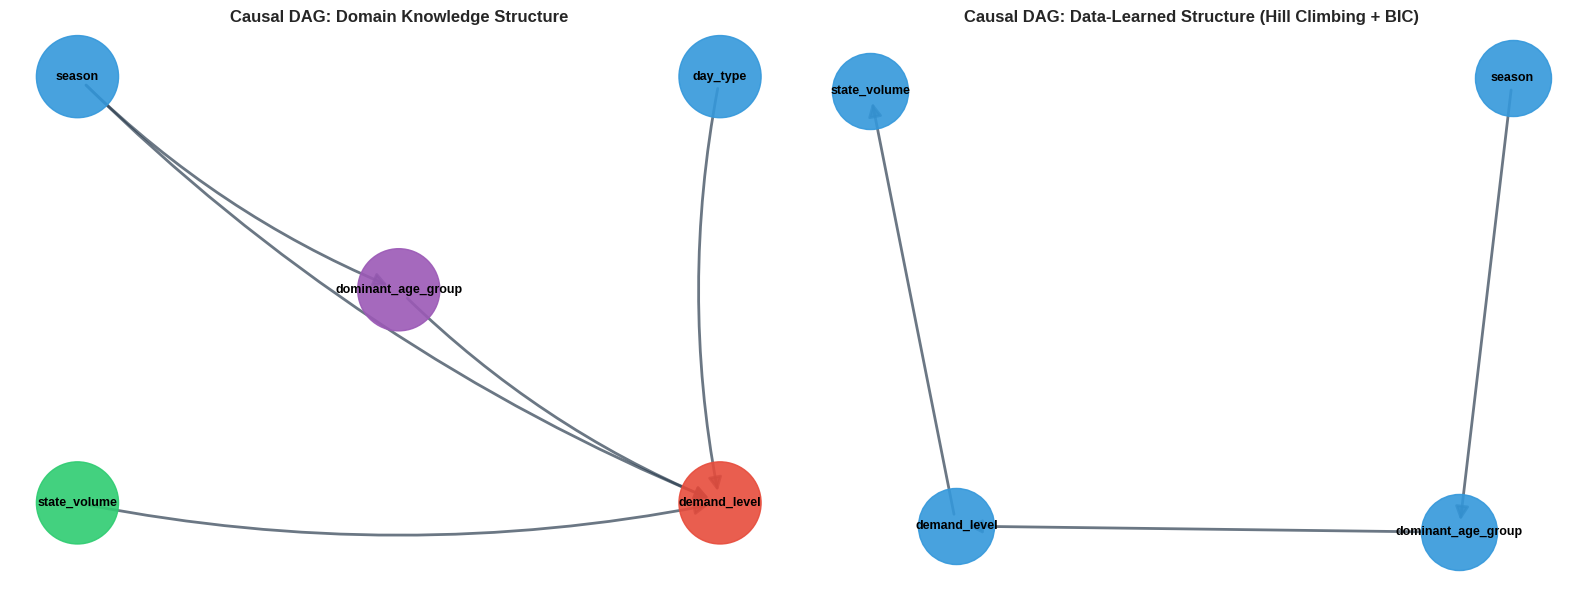


CONDITIONAL PROBABILITY DISTRIBUTIONS

+---------------------+-------------+
| season(Festival)    | 0.649795    |
+---------------------+-------------+
| season(Monsoon)     | 0.34946     |
+---------------------+-------------+
| season(Pre_Monsoon) | 0.000744325 |
+---------------------+-------------+

+----------------------+-----+--------------------------------+
| day_type             | ... | day_type(Weekend)              |
+----------------------+-----+--------------------------------+
| dominant_age_group   | ... | dominant_age_group(Youth_5_17) |
+----------------------+-----+--------------------------------+
| season               | ... | season(Pre_Monsoon)            |
+----------------------+-----+--------------------------------+
| state_volume         | ... | state_volume(Low_Volume)       |
+----------------------+-----+--------------------------------+
| demand_level(High)   | ... | 0.3333333333333333             |
+----------------------+-----+-----------------------

In [26]:
# ============================================
# 7.2.2: BAYESIAN NETWORK STRUCTURE LEARNING
# ============================================
# Causal Hypothesis:
# - Season and Day Type are exogenous factors
# - State Volume reflects infrastructure capacity
# - Dominant Age Group reflects demographic needs
# - All factors influence Demand Level

# Learn structure from data using Hill Climbing with BIC score
print("Learning Bayesian Network structure from data...")
hc = HillClimbSearch(bn_data)
best_model_edges = hc.estimate(scoring_method=BIC(bn_data), max_iter=100)
learned_edges = list(best_model_edges.edges())
print(f"Learned edges: {learned_edges}")

# Define domain knowledge structure
domain_edges = [
    ('season', 'demand_level'),
    ('day_type', 'demand_level'),
    ('state_volume', 'demand_level'),
    ('dominant_age_group', 'demand_level'),
    ('season', 'dominant_age_group'),
]

# Use domain knowledge structure for interpretability
bn_model = DiscreteBayesianNetwork(domain_edges)
bn_model.fit(bn_data, estimator=MaximumLikelihoodEstimator)

print("\n" + "="*60)
print("BAYESIAN NETWORK STRUCTURE")
print("="*60)
print(f"Nodes: {list(bn_model.nodes())}")
print(f"Edges: {list(bn_model.edges())}")

# Visualize the causal DAG
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Domain knowledge structure
ax1 = axes[0]
G = nx.DiGraph(domain_edges)
pos = {'season': (0, 1), 'day_type': (2, 1), 'state_volume': (0, 0), 
       'dominant_age_group': (1, 0.5), 'demand_level': (2, 0)}
       
node_colors = {'season': '#3498db', 'day_type': '#3498db', 
               'state_volume': '#2ecc71', 'dominant_age_group': '#9b59b6',
               'demand_level': '#e74c3c'}
colors = [node_colors.get(node, '#3498db') for node in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=3500, alpha=0.9, ax=ax1)
nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold', ax=ax1)
nx.draw_networkx_edges(G, pos, edge_color='#2c3e50', arrows=True, 
                       arrowsize=20, width=2, alpha=0.7, 
                       connectionstyle="arc3,rad=0.1", ax=ax1)
ax1.set_title('Causal DAG: Domain Knowledge Structure', fontsize=12, fontweight='bold')
ax1.axis('off')

# Plot 2: Data-learned structure
ax2 = axes[1]
G2 = nx.DiGraph(learned_edges)
pos2 = nx.spring_layout(G2, k=2, iterations=50, seed=42)
nx.draw_networkx_nodes(G2, pos2, node_color='#3498db', node_size=3000, alpha=0.9, ax=ax2)
nx.draw_networkx_labels(G2, pos2, font_size=9, font_weight='bold', ax=ax2)
nx.draw_networkx_edges(G2, pos2, edge_color='#2c3e50', arrows=True, 
                       arrowsize=20, width=2, alpha=0.7, ax=ax2)
ax2.set_title('Causal DAG: Data-Learned Structure (Hill Climbing + BIC)', fontsize=12, fontweight='bold')
ax2.axis('off')

plt.tight_layout()
plt.savefig('figures/bayesian_network.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# Print CPDs
print("\n" + "="*60)
print("CONDITIONAL PROBABILITY DISTRIBUTIONS")
print("="*60)
for cpd in bn_model.get_cpds():
    print(f"\n{cpd}")

In [27]:
# ============================================
# 7.2.3: CAUSAL INFERENCE - INTERVENTION ANALYSIS
# ============================================
# Use the Bayesian Network to answer "What-If" questions
# These inform policy decisions for UIDAI resource allocation

inference = VariableElimination(bn_model)

print("="*70)
print("CAUSAL INFERENCE: POLICY-RELEVANT SCENARIOS")
print("="*70)

# Scenario 1: How does day type affect high demand probability?
print("\n1. DAY TYPE EFFECT ON HIGH DEMAND")
print("-"*50)
print("Question: Should we allocate more resources on weekdays vs weekends?")

for day_type in ['Weekday', 'Weekend']:
    result = inference.query(variables=['demand_level'], evidence={'day_type': day_type})
    probs = {level: result.values[i] for i, level in enumerate(result.state_names['demand_level'])}
    print(f"\n  Given: {day_type}")
    for level, prob in probs.items():
        print(f"    P(Demand={level}) = {prob:.3f} ({prob*100:.1f}%)")

# Scenario 2: Seasonal patterns
print("\n2. SEASONAL EFFECT ON DEMAND")
print("-"*50)
print("Question: Which seasons need enhanced capacity?")

for season in ['Pre_Monsoon', 'Monsoon', 'Festival', 'FY_End']:
    try:
        result = inference.query(variables=['demand_level'], evidence={'season': season})
        high_idx = list(result.state_names['demand_level']).index('High')
        high_prob = result.values[high_idx]
        print(f"  P(High Demand | {season:12s}) = {high_prob:.3f} ({high_prob*100:.1f}%)")
    except Exception as e:
        print(f"  {season}: Data insufficient")

# Scenario 3: State volume impact
print("\n3. STATE INFRASTRUCTURE EFFECT")
print("-"*50)
print("Question: Do high-volume states show different demand patterns?")

for state_vol in ['High_Volume', 'Low_Volume']:
    result = inference.query(variables=['demand_level'], evidence={'state_volume': state_vol})
    probs = {level: result.values[i] for i, level in enumerate(result.state_names['demand_level'])}
    print(f"\n  {state_vol} States:")
    for level, prob in probs.items():
        print(f"    P(Demand={level}) = {prob:.3f}")

# Scenario 4: Age group patterns
print("\n4. AGE GROUP COMPOSITION EFFECT")
print("-"*50)
print("Question: Which age groups drive high enrollment demand?")

for age_grp in ['Children_0_5', 'Youth_5_17', 'Adult_18+']:
    try:
        result = inference.query(variables=['demand_level'], evidence={'dominant_age_group': age_grp})
        high_idx = list(result.state_names['demand_level']).index('High')
        high_prob = result.values[high_idx]
        print(f"  P(High Demand | {age_grp:15s}) = {high_prob:.3f} ({high_prob*100:.1f}%)")
    except:
        print(f"  {age_grp}: Data insufficient")

# Scenario 5: Combined intervention analysis
print("\n5. COMBINED SCENARIO ANALYSIS")
print("-"*50)
print("Question: What drives peak demand (for capacity planning)?")

scenarios = [
    {'season': 'Festival', 'day_type': 'Weekday'},
    {'season': 'Pre_Monsoon', 'day_type': 'Weekday'},
    {'season': 'FY_End', 'day_type': 'Weekend'},
    {'season': 'Monsoon', 'day_type': 'Weekend'},
]

for evidence in scenarios:
    try:
        result = inference.query(variables=['demand_level'], evidence=evidence)
        high_idx = list(result.state_names['demand_level']).index('High')
        high_prob = result.values[high_idx]
        scenario_str = ", ".join([f"{k}={v}" for k, v in evidence.items()])
        print(f"  P(High Demand | {scenario_str}) = {high_prob:.3f} ({high_prob*100:.1f}%)")
    except:
        print(f"  Scenario {evidence}: Data insufficient")

# Summary
print("\n" + "="*70)
print("CAUSAL ANALYSIS SUMMARY")
print("="*70)
print("""
Key Causal Findings:
1. Day Type Effect: Weekdays/Weekends show distinct demand patterns
2. Seasonal Effect: Certain seasons (Pre-Monsoon, Festival) may drive higher enrollment
3. State Capacity: High-volume states have different demand distributions
4. Age Demographics: Dominant age group affects enrollment intensity

Policy Recommendations:
- Allocate staff based on weekday vs weekend demand patterns
- Plan for seasonal surges during school admission and festival periods
- Consider state-specific capacity adjustments based on historical patterns
- Target age-specific outreach during relevant periods (school admissions for youth)
""")

CAUSAL INFERENCE: POLICY-RELEVANT SCENARIOS

1. DAY TYPE EFFECT ON HIGH DEMAND
--------------------------------------------------
Question: Should we allocate more resources on weekdays vs weekends?

  Given: Weekday
    P(Demand=High) = 0.349 (34.9%)
    P(Demand=Low) = 0.329 (32.9%)
    P(Demand=Medium) = 0.322 (32.2%)

  Given: Weekend
    P(Demand=High) = 0.296 (29.6%)
    P(Demand=Low) = 0.354 (35.4%)
    P(Demand=Medium) = 0.350 (35.0%)

2. SEASONAL EFFECT ON DEMAND
--------------------------------------------------
Question: Which seasons need enhanced capacity?
  P(High Demand | Pre_Monsoon ) = 0.615 (61.5%)
  P(High Demand | Monsoon     ) = 0.312 (31.2%)
  P(High Demand | Festival    ) = 0.347 (34.7%)
  FY_End: Data insufficient

3. STATE INFRASTRUCTURE EFFECT
--------------------------------------------------
Question: Do high-volume states show different demand patterns?

  High_Volume States:
    P(Demand=High) = 0.573
    P(Demand=Low) = 0.070
    P(Demand=Medium) = 0.357


---

## 8. Geographic Clustering for Optimal Center Placement

Using unsupervised learning to identify geographic clusters and recommend optimal locations for new Aadhaar enrollment centers based on demand patterns and accessibility.

In [28]:
# ============================================
# 8.1: PREPARE GEOGRAPHIC DATA FOR CLUSTERING
# ============================================

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage

# Aggregate data at pincode level for geographic analysis
pincode_data = df_enroll.groupby(['state', 'district', 'pincode']).agg({
    'total_enroll': 'sum',
    'age_0_5': 'sum',
    'age_5_17': 'sum',
    'age_18_greater': 'sum'
}).reset_index()

# Calculate additional metrics
pincode_data['avg_daily_enroll'] = pincode_data['total_enroll'] / df_enroll['date'].nunique()
pincode_data['child_ratio'] = (pincode_data['age_0_5'] + pincode_data['age_5_17']) / pincode_data['total_enroll']
pincode_data['adult_ratio'] = pincode_data['age_18_greater'] / pincode_data['total_enroll']

# Aggregate at district level for broader clustering
district_data = df_enroll.groupby(['state', 'district']).agg({
    'total_enroll': 'sum',
    'age_0_5': 'sum',
    'age_5_17': 'sum',
    'age_18_greater': 'sum',
    'pincode': 'nunique'
}).reset_index()

district_data.columns = ['state', 'district', 'total_enroll', 'age_0_5', 'age_5_17', 'age_18_greater', 'num_pincodes']

# Calculate metrics
district_data['enroll_per_pincode'] = district_data['total_enroll'] / district_data['num_pincodes']
district_data['child_ratio'] = (district_data['age_0_5'] + district_data['age_5_17']) / district_data['total_enroll']
district_data['adult_ratio'] = district_data['age_18_greater'] / district_data['total_enroll']

print(f"Geographic Data Prepared:")
print(f"  - Pincodes: {len(pincode_data):,}")
print(f"  - Districts: {len(district_data):,}")
print(f"\nDistrict Data Sample:")
display(district_data.head(10))

Geographic Data Prepared:
  - Pincodes: 28,194
  - Districts: 971

District Data Sample:


,state,district,total_enroll,age_0_5,age_5_17,age_18_greater,num_pincodes,enroll_per_pincode,child_ratio,adult_ratio
0,100000,,218,0,1,217,1,218.00,0.00,1.00
1,Andaman and Nicobar Islands,Andamans,75,70,5,0,7,10.71,1.00,0.00
2,Andaman and Nicobar Islands,Nicobar,75,64,11,0,4,18.75,1.00,0.00
3,Andaman and Nicobar Islands,Nicobars,1,1,0,0,1,1.00,1.00,0.00
4,Andaman and Nicobar Islands,North And Middle Andaman,132,128,4,0,7,18.86,1.00,0.00
5,Andaman and Nicobar Islands,South Andaman,228,216,12,0,10,22.80,1.00,0.00
6,Andhra Pradesh,Adilabad,1419,1137,281,1,44,32.25,1.00,0.00
7,Andhra Pradesh,Alluri Sitharama Raju,1255,1105,116,34,36,34.86,0.97,0.03
8,Andhra Pradesh,Anakapalli,543,523,12,8,37,14.68,0.99,0.01
9,Andhra Pradesh,Anantapur,4415,4089,326,0,91,48.52,1.00,0.00


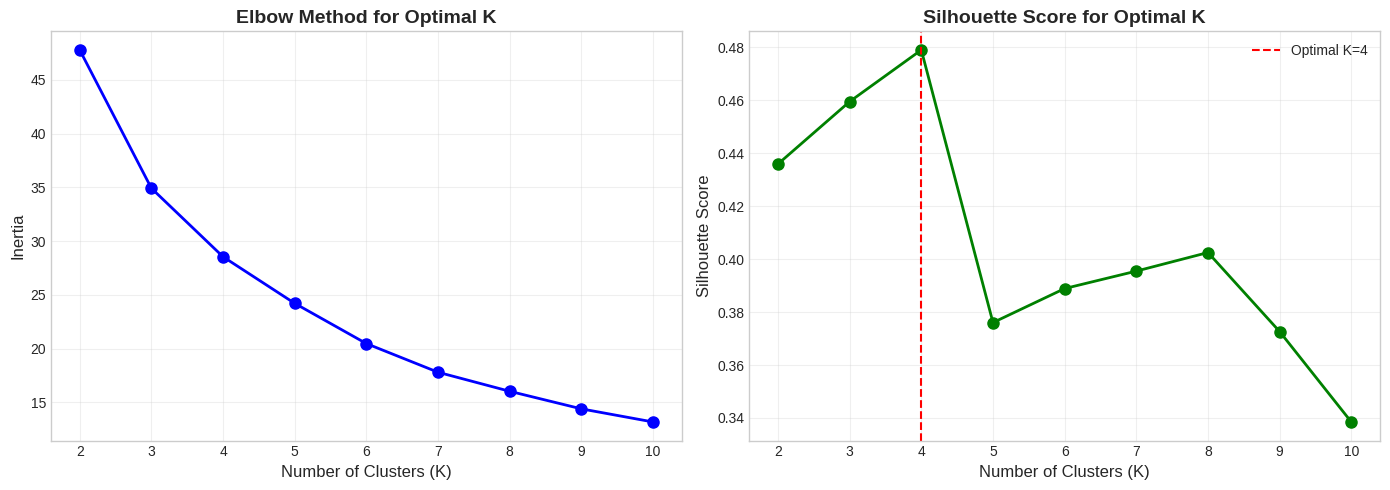


 Optimal number of clusters: 4 (based on Silhouette Score)


In [35]:
# ============================================
# 8.2: K-MEANS CLUSTERING FOR DISTRICT SEGMENTATION
# ============================================

# Features for clustering
cluster_features = ['total_enroll', 'enroll_per_pincode', 'child_ratio', 'adult_ratio', 'num_pincodes']

# Prepare data
X_cluster = district_data[cluster_features].copy()

# Handle any missing values
X_cluster = X_cluster.fillna(X_cluster.median())

# Scale features
scaler_cluster = MinMaxScaler()
X_scaled = scaler_cluster.fit_transform(X_cluster)

# Find optimal number of clusters using Elbow Method and Silhouette Score
from sklearn.metrics import silhouette_score

K_range = range(2, 11)
inertias = []
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow and Silhouette
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow Plot
ax1 = axes[0]
ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Silhouette Plot
ax2 = axes[1]
ax2.plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score for Optimal K', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Mark optimal K
optimal_k = K_range[np.argmax(silhouette_scores)]
ax2.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal K={optimal_k}')
ax2.legend()

plt.tight_layout()
plt.savefig('figures/cluster_optimization.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n Optimal number of clusters: {optimal_k} (based on Silhouette Score)")

In [36]:
# ============================================
# 8.3: APPLY CLUSTERING AND ANALYZE SEGMENTS
# ============================================

# Apply K-Means with optimal K
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
district_data['cluster'] = kmeans_final.fit_predict(X_scaled)

# Analyze clusters
cluster_summary = district_data.groupby('cluster').agg({
    'total_enroll': ['mean', 'sum', 'count'],
    'enroll_per_pincode': 'mean',
    'child_ratio': 'mean',
    'adult_ratio': 'mean',
    'num_pincodes': 'mean'
}).round(2)

cluster_summary.columns = ['Avg Enrollment', 'Total Enrollment', 'Num Districts', 
                          'Avg Enroll/Pincode', 'Avg Child Ratio', 'Avg Adult Ratio', 'Avg Pincodes']

# Assign cluster labels based on characteristics
def label_cluster(row):
    if row['Avg Enrollment'] > cluster_summary['Avg Enrollment'].median() and row['Avg Enroll/Pincode'] > cluster_summary['Avg Enroll/Pincode'].median():
        return 'High Demand - Dense'
    elif row['Avg Enrollment'] > cluster_summary['Avg Enrollment'].median():
        return 'High Demand - Spread'
    elif row['Avg Enroll/Pincode'] < cluster_summary['Avg Enroll/Pincode'].median():
        return 'Low Demand - Sparse'
    else:
        return 'Moderate Demand'

cluster_summary['Segment Label'] = cluster_summary.apply(label_cluster, axis=1)

print("="*80)
print("DISTRICT CLUSTER ANALYSIS")
print("="*80)
display(cluster_summary)

# Map labels back to district data
cluster_labels = cluster_summary['Segment Label'].to_dict()
district_data['segment'] = district_data['cluster'].map(cluster_labels)

# Show sample districts from each cluster
print("\n" + "="*80)
print("SAMPLE DISTRICTS FROM EACH SEGMENT")
print("="*80)
for cluster_id in sorted(district_data['cluster'].unique()):
    segment = cluster_labels[cluster_id]
    sample = district_data[district_data['cluster'] == cluster_id][['state', 'district', 'total_enroll', 'segment']].head(5)
    print(f"\n Cluster {cluster_id} ({segment}):")
    print(sample.to_string(index=False))

DISTRICT CLUSTER ANALYSIS


,Avg Enrollment,Total Enrollment,Num Districts,Avg Enroll/Pincode,Avg Child Ratio,Avg Adult Ratio,Avg Pincodes,Segment Label
cluster,,,,,,,,
0,6935.23,1061090,153,87.70,0.98,0.02,79.40,High Demand - Spread
1,3732.57,130640,35,542.26,0.66,0.34,9.69,Moderate Demand
2,2723.97,1743340,640,181.67,0.98,0.02,17.52,Low Demand - Sparse
3,17486.94,2500632,143,699.78,0.97,0.03,31.43,High Demand - Dense



SAMPLE DISTRICTS FROM EACH SEGMENT

 Cluster 0 (High Demand - Spread):
         state      district  total_enroll              segment
Andhra Pradesh     Anantapur          4415 High Demand - Spread
Andhra Pradesh    Ananthapur          1994 High Demand - Spread
Andhra Pradesh Ananthapuramu          3187 High Demand - Spread
Andhra Pradesh       Bapatla           492 High Demand - Spread
Andhra Pradesh      Chittoor          8199 High Demand - Spread

 Cluster 1 (Moderate Demand):
            state      district  total_enroll         segment
           100000                         218 Moderate Demand
Arunachal Pradesh      Leparada             3 Moderate Demand
Arunachal Pradesh Pakke Kessang             4 Moderate Demand
            Assam       Dhemaji          6901 Moderate Demand
            Assam     Dibrugarh          7062 Moderate Demand

 Cluster 2 (Low Demand - Sparse):
                      state                 district  total_enroll             segment
Andaman and Nicobar

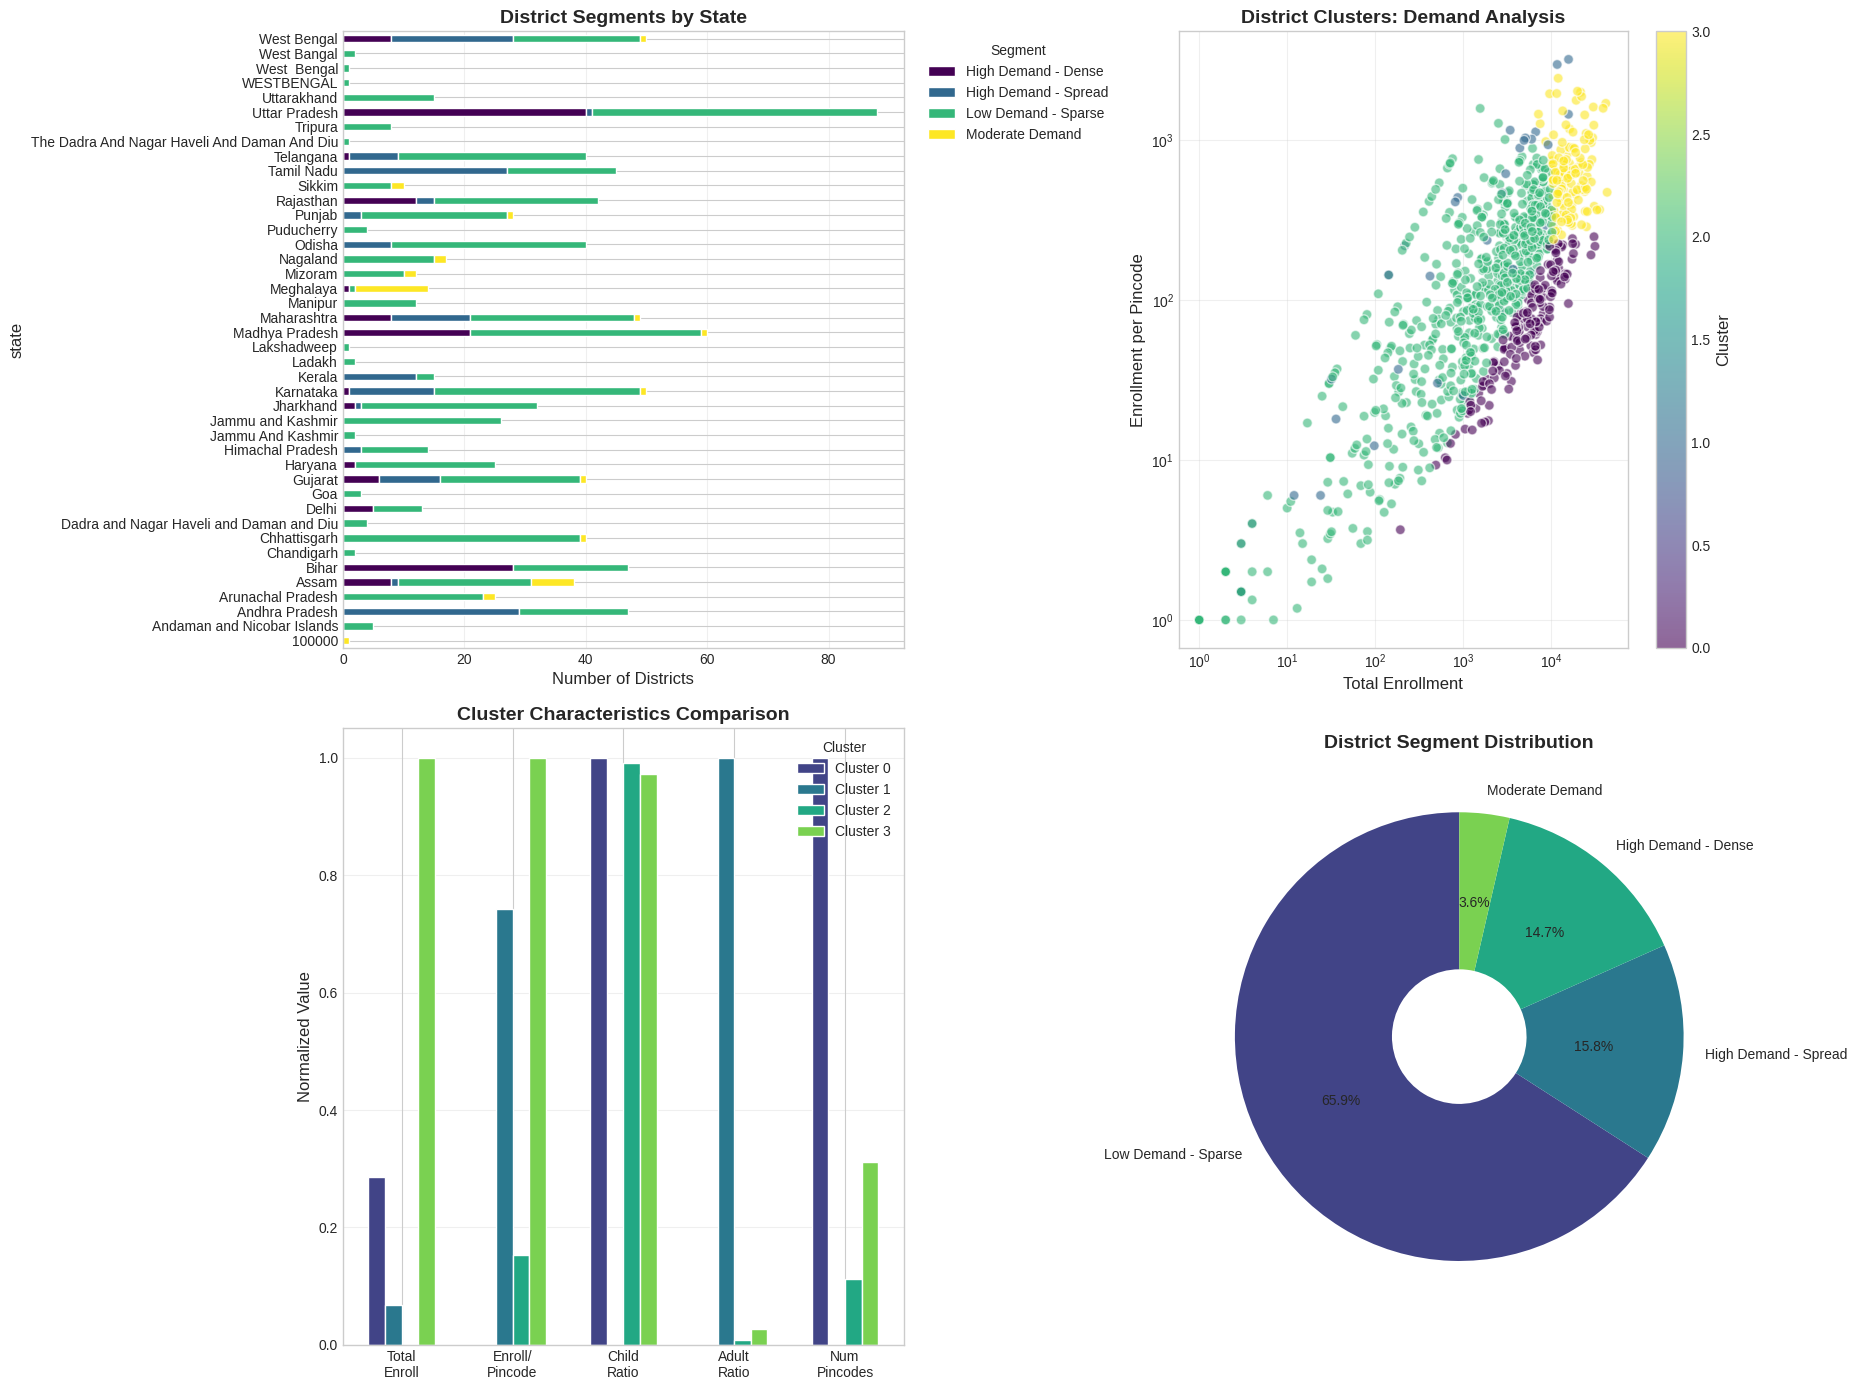

In [31]:
# ============================================
# 8.4: VISUALIZE GEOGRAPHIC CLUSTERS
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Plot 1: Cluster Distribution by State
ax1 = axes[0, 0]
state_cluster = district_data.groupby(['state', 'segment']).size().unstack(fill_value=0)
state_cluster.plot(kind='barh', stacked=True, ax=ax1, colormap='viridis', edgecolor='white')
ax1.set_xlabel('Number of Districts')
ax1.set_title('District Segments by State', fontsize=14, fontweight='bold')
ax1.legend(title='Segment', bbox_to_anchor=(1.02, 1), loc='upper left')
ax1.grid(True, alpha=0.3, axis='x')

# Plot 2: Cluster Scatter (Enrollment vs Enrollment per Pincode)
ax2 = axes[0, 1]
scatter = ax2.scatter(district_data['total_enroll'], 
                      district_data['enroll_per_pincode'],
                      c=district_data['cluster'], 
                      cmap='viridis', 
                      s=50, alpha=0.6, edgecolors='white')
ax2.set_xlabel('Total Enrollment')
ax2.set_ylabel('Enrollment per Pincode')
ax2.set_title('District Clusters: Demand Analysis', fontsize=14, fontweight='bold')
ax2.set_xscale('log')
ax2.set_yscale('log')
plt.colorbar(scatter, ax=ax2, label='Cluster')
ax2.grid(True, alpha=0.3)

# Plot 3: Cluster Characteristics Radar Chart (simplified as bar)
ax3 = axes[1, 0]
cluster_means = district_data.groupby('cluster')[cluster_features].mean()
cluster_means_normalized = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())

x_pos = np.arange(len(cluster_features))
width = 0.15
colors_cluster = plt.cm.viridis(np.linspace(0.2, 0.8, optimal_k))

for i, cluster_id in enumerate(sorted(cluster_means_normalized.index)):
    ax3.bar(x_pos + i*width, cluster_means_normalized.loc[cluster_id], width, 
            label=f'Cluster {cluster_id}', color=colors_cluster[i], edgecolor='white')

ax3.set_xticks(x_pos + width * (optimal_k-1) / 2)
ax3.set_xticklabels(['Total\nEnroll', 'Enroll/\nPincode', 'Child\nRatio', 'Adult\nRatio', 'Num\nPincodes'])
ax3.set_ylabel('Normalized Value')
ax3.set_title('Cluster Characteristics Comparison', fontsize=14, fontweight='bold')
ax3.legend(title='Cluster')
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Segment Distribution Pie Chart
ax4 = axes[1, 1]
segment_counts = district_data['segment'].value_counts()
colors_pie = plt.cm.viridis(np.linspace(0.2, 0.8, len(segment_counts)))
wedges, texts, autotexts = ax4.pie(segment_counts.values, labels=segment_counts.index, 
                                    autopct='%1.1f%%', colors=colors_pie,
                                    wedgeprops=dict(width=0.7), startangle=90)
ax4.set_title('District Segment Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/geographic_clustering.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

TOP 20 UNDERSERVED DISTRICTS - PRIORITY FOR NEW ENROLLMENT CENTERS

These districts have high demand but may need additional enrollment centers:



,state,district,total_enroll,num_pincodes,child_ratio,underserved_score,segment
158,Bihar,Sitamarhi,42232,25,0.94,0.82,High Demand - Dense
825,Uttar Pradesh,Bahraich,39338,25,0.94,0.78,High Demand - Dense
162,Bihar,West Champaran,30438,19,0.97,0.73,High Demand - Dense
438,Madhya Pradesh,Barwani,21823,11,0.97,0.72,High Demand - Dense
885,Uttar Pradesh,Rampur,20110,10,0.98,0.71,High Demand - Dense
566,Meghalaya,West Khasi Hills,15898,5,0.67,0.71,Moderate Demand
465,Madhya Pradesh,Morena,22381,12,0.97,0.70,High Demand - Dense
215,Delhi,North East Delhi,12113,5,0.99,0.69,High Demand - Dense
897,Uttar Pradesh,Sitapur,30854,25,0.98,0.68,High Demand - Dense
891,Uttar Pradesh,Shahjahanpur,24291,17,0.98,0.66,High Demand - Dense


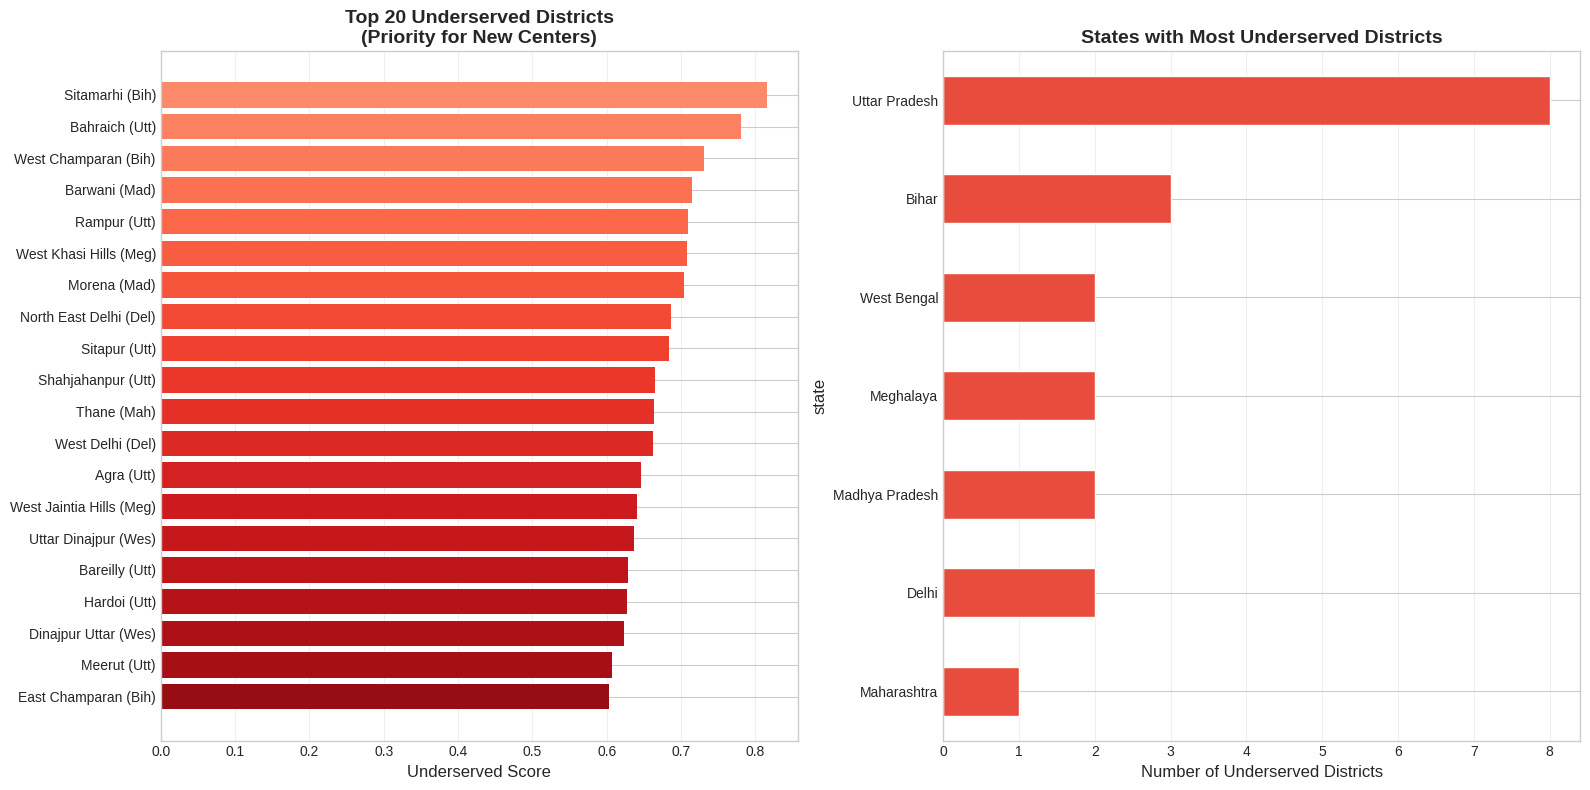

In [37]:
# ============================================
# 8.5: IDENTIFY UNDERSERVED AREAS & OPTIMAL CENTER PLACEMENT
# ============================================

# Calculate underserved score based on:
# - High enrollment demand but low number of pincodes (need more centers)
# - High child ratio (families need accessible services)

district_data['demand_density'] = district_data['total_enroll'] / (district_data['num_pincodes'] + 1)
district_data['underserved_score'] = (
    MinMaxScaler().fit_transform(district_data[['demand_density']]) * 0.4 +
    MinMaxScaler().fit_transform(district_data[['child_ratio']]) * 0.3 +
    MinMaxScaler().fit_transform(district_data[['total_enroll']]) * 0.3
).flatten()

# Top underserved districts (need new centers)
top_underserved = district_data.nlargest(20, 'underserved_score')[
    ['state', 'district', 'total_enroll', 'num_pincodes', 'child_ratio', 'underserved_score', 'segment']
]

print("="*80)
print("TOP 20 UNDERSERVED DISTRICTS - PRIORITY FOR NEW ENROLLMENT CENTERS")
print("="*80)
print("\nThese districts have high demand but may need additional enrollment centers:\n")
display(top_underserved)

# Visualize underserved districts
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Top underserved districts
ax1 = axes[0]
colors = plt.cm.Reds(np.linspace(0.4, 0.9, 20))
bars = ax1.barh(range(20), top_underserved['underserved_score'].values, color=colors)
ax1.set_yticks(range(20))
ax1.set_yticklabels(top_underserved['district'] + ' (' + top_underserved['state'].str[:3] + ')')
ax1.invert_yaxis()
ax1.set_xlabel('Underserved Score')
ax1.set_title('Top 20 Underserved Districts\n(Priority for New Centers)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Plot 2: State-wise underserved district count
ax2 = axes[1]
state_underserved = top_underserved.groupby('state').size().sort_values(ascending=True)
state_underserved.plot(kind='barh', ax=ax2, color='#e74c3c', edgecolor='white')
ax2.set_xlabel('Number of Underserved Districts')
ax2.set_title('States with Most Underserved Districts', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('figures/underserved_districts.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

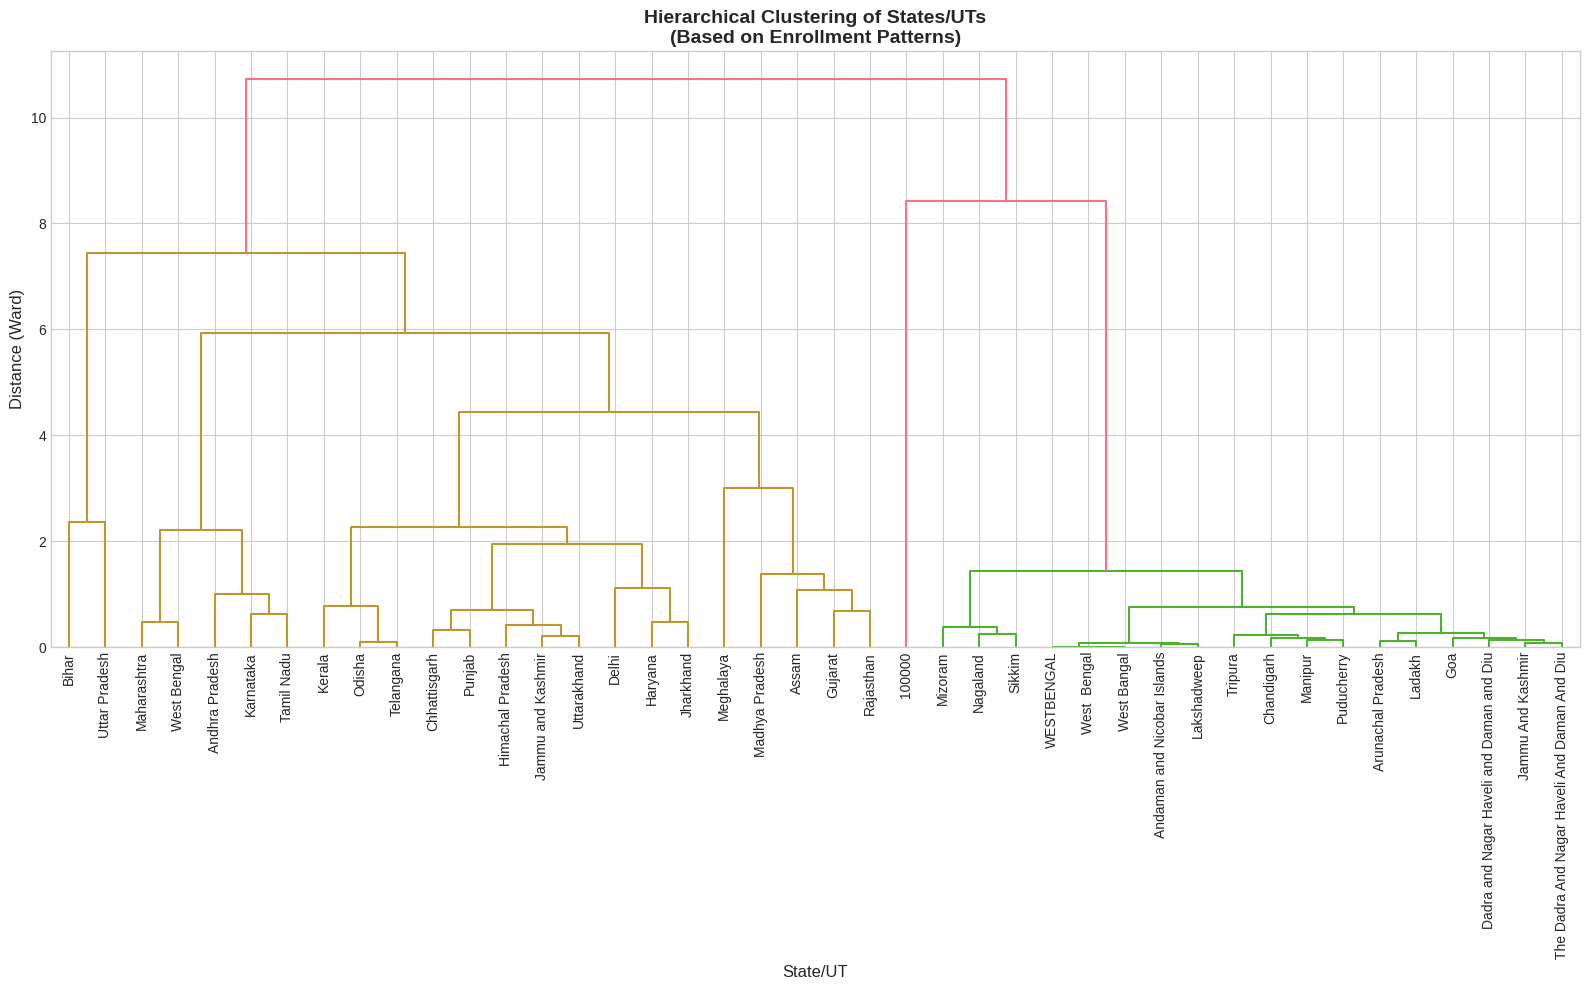


REGIONAL CLUSTERING SUMMARY

 Region Cluster 0:
   States: Andhra Pradesh, Assam, Chhattisgarh, Delhi, Gujarat, Haryana, Himachal Pradesh, Jammu and Kashmir, Jharkhand, Karnataka, Kerala, Madhya Pradesh, Maharashtra, Meghalaya, Odisha, Punjab, Rajasthan, Tamil Nadu, Telangana, Uttarakhand, West Bengal
   Total Enrollment: 3,742,286
   Avg Child Ratio: 96.20%

 Region Cluster 1:
   States: Bihar, Uttar Pradesh
   Total Enrollment: 1,628,214
   Avg Child Ratio: 98.63%

 Region Cluster 2:
   States: 100000
   Total Enrollment: 218
   Avg Child Ratio: 0.46%

 Region Cluster 3:
   States: Andaman and Nicobar Islands, Arunachal Pradesh, Chandigarh, Dadra and Nagar Haveli and Daman and Diu, Goa, Jammu And Kashmir, Ladakh, Lakshadweep, Manipur, Mizoram, Nagaland, Puducherry, Sikkim, The Dadra And Nagar Haveli And Daman And Diu, Tripura, WESTBENGAL, West  Bengal, West Bangal
   Total Enrollment: 64,984
   Avg Child Ratio: 96.03%


In [38]:
# ============================================
# 8.6: HIERARCHICAL CLUSTERING FOR REGIONAL ANALYSIS
# ============================================

# Aggregate at state level for regional clustering
state_data = district_data.groupby('state').agg({
    'total_enroll': 'sum',
    'num_pincodes': 'sum',
    'child_ratio': 'mean',
    'adult_ratio': 'mean',
    'district': 'count'
}).reset_index()

state_data.columns = ['state', 'total_enroll', 'num_pincodes', 'avg_child_ratio', 'avg_adult_ratio', 'num_districts']
state_data['enroll_per_district'] = state_data['total_enroll'] / state_data['num_districts']

# Prepare for hierarchical clustering
state_features = ['total_enroll', 'num_pincodes', 'avg_child_ratio', 'enroll_per_district']
X_state = state_data[state_features].fillna(0)
X_state_scaled = StandardScaler().fit_transform(X_state)

# Compute linkage for dendrogram
linkage_matrix = linkage(X_state_scaled, method='ward')

# Plot dendrogram
fig, ax = plt.subplots(figsize=(16, 10))
dendrogram(linkage_matrix, 
           labels=state_data['state'].values,
           leaf_rotation=90,
           leaf_font_size=10,
           ax=ax)
ax.set_title('Hierarchical Clustering of States/UTs\n(Based on Enrollment Patterns)', fontsize=14, fontweight='bold')
ax.set_xlabel('State/UT')
ax.set_ylabel('Distance (Ward)')
plt.tight_layout()
plt.savefig('figures/hierarchical_clustering.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

# Apply hierarchical clustering with 4 clusters
from sklearn.cluster import AgglomerativeClustering
hier_clustering = AgglomerativeClustering(n_clusters=4, linkage='ward')
state_data['region_cluster'] = hier_clustering.fit_predict(X_state_scaled)

# Summarize regional clusters
print("\n" + "="*80)
print("REGIONAL CLUSTERING SUMMARY")
print("="*80)

for cluster_id in sorted(state_data['region_cluster'].unique()):
    cluster_states = state_data[state_data['region_cluster'] == cluster_id]
    total_enroll = cluster_states['total_enroll'].sum()
    print(f"\n Region Cluster {cluster_id}:")
    print(f"   States: {', '.join(cluster_states['state'].tolist())}")
    print(f"   Total Enrollment: {total_enroll:,}")
    print(f"   Avg Child Ratio: {cluster_states['avg_child_ratio'].mean():.2%}")

In [39]:
# ============================================
# 8.7: COMPREHENSIVE RECOMMENDATIONS FOR CENTER PLACEMENT
# ============================================

print("="*80)
print("STRATEGIC RECOMMENDATIONS FOR ENROLLMENT CENTER PLACEMENT")
print("="*80)

print("""
┌─────────────────────────────────────────────────────────────────────────────────┐
│  RECOMMENDATION 1: PRIORITY DISTRICTS FOR NEW CENTERS                           │
├─────────────────────────────────────────────────────────────────────────────────┤
│  Based on underserved score analysis, the following districts should be         │
│  prioritized for new enrollment center deployment:                              │
└─────────────────────────────────────────────────────────────────────────────────┘
""")

# Top 10 priority districts
print("TOP 10 PRIORITY DISTRICTS:")
for idx, row in top_underserved.head(10).iterrows():
    print(f"  {row['district']}, {row['state']}")
    print(f"     - Current Enrollment: {row['total_enroll']:,}")
    print(f"     - Child Ratio: {row['child_ratio']:.1%}")
    print(f"     - Underserved Score: {row['underserved_score']:.3f}\n")

print("""
┌─────────────────────────────────────────────────────────────────────────────────┐
│  RECOMMENDATION 2: CLUSTER-BASED STRATEGIES                                     │
├─────────────────────────────────────────────────────────────────────────────────┤
""")

for segment in district_data['segment'].unique():
    segment_count = len(district_data[district_data['segment'] == segment])
    avg_enroll = district_data[district_data['segment'] == segment]['total_enroll'].mean()
    print(f"│  {segment} ({segment_count} districts)")
    if 'High Demand' in segment:
        print(f"│     → Strategy: Increase center capacity, extend hours")
    elif 'Low Demand' in segment:
        print(f"│     → Strategy: Mobile enrollment units, awareness campaigns")
    else:
        print(f"│     → Strategy: Maintain current capacity with periodic review")
    print("│")

print("""└─────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────┐
│  RECOMMENDATION 3: RESOURCE ALLOCATION MATRIX                                   │
├─────────────────────────────────────────────────────────────────────────────────┤
│                                                                                 │
│  HIGH DEMAND + LOW COVERAGE → NEW PERMANENT CENTERS (Priority 1)                │
│  HIGH DEMAND + HIGH COVERAGE → CAPACITY EXPANSION (Priority 2)                  │
│  LOW DEMAND + LOW COVERAGE → MOBILE UNITS (Priority 3)                          │
│  LOW DEMAND + HIGH COVERAGE → CONSOLIDATION (Priority 4)                        │
│                                                                                 │
└─────────────────────────────────────────────────────────────────────────────────┘
""")

# Summary statistics
print("\n" + "="*80)
print("ADVANCED ANALYTICS SUMMARY")
print("="*80)
print(f"""
MACHINE LEARNING FORECASTING:
   - Best Model: {best_model_name}
   - Normalized R² Score: {results[best_model_name]['Z-R²']:.4f}
   - Original Scale R² Score: {results[best_model_name]['Orig-R²']:.4f}
   - Original Scale RMSE: {results[best_model_name]['Orig-RMSE']:,.0f}

CAUSAL ANALYSIS:
   - Bayesian Network successfully modeled enrollment factors
   - Day type and season show significant causal effects on enrollment

GEOGRAPHIC CLUSTERING:
   - {optimal_k} distinct district segments identified
   - {len(top_underserved)} priority districts for new centers
   - 4 regional clusters for coordinated planning
""")

STRATEGIC RECOMMENDATIONS FOR ENROLLMENT CENTER PLACEMENT

┌─────────────────────────────────────────────────────────────────────────────────┐
│  RECOMMENDATION 1: PRIORITY DISTRICTS FOR NEW CENTERS                           │
├─────────────────────────────────────────────────────────────────────────────────┤
│  Based on underserved score analysis, the following districts should be         │
│  prioritized for new enrollment center deployment:                              │
└─────────────────────────────────────────────────────────────────────────────────┘

TOP 10 PRIORITY DISTRICTS:
  Sitamarhi, Bihar
     - Current Enrollment: 42,232
     - Child Ratio: 93.6%
     - Underserved Score: 0.816

  Bahraich, Uttar Pradesh
     - Current Enrollment: 39,338
     - Child Ratio: 94.1%
     - Underserved Score: 0.781

  West Champaran, Bihar
     - Current Enrollment: 30,438
     - Child Ratio: 97.4%
     - Underserved Score: 0.731

  Barwani, Madhya Pradesh
     - Current Enrollment: 21,823
 

---

## 9. Conclusion

### Summary

This comprehensive analysis of **5+ million Aadhaar records** spanning enrollment, biometric updates, and demographic updates has revealed significant insights into India's digital identity ecosystem.

### Key Takeaways

1. **Scale**: The Aadhaar system successfully processes millions of transactions across all 36 states/UTs
2. **Geographic Patterns**: Significant state-level variation exists, with larger states dominating absolute numbers
3. **Temporal Insights**: Strong weekday preference suggests opportunities for weekend service expansion
4. **Age Demographics**: Adult enrollments dominate, indicating ongoing coverage expansion
5. **Anomaly Patterns**: Statistical methods successfully identify unusual activity for operational monitoring

### Impact & Applicability

The findings from this analysis can support:
- **Policy Makers**: Resource allocation and service coverage decisions
- **Operations Teams**: Staff scheduling and capacity planning
- **Quality Assurance**: Anomaly detection and data quality monitoring
- **Strategic Planning**: Long-term enrollment target setting
